# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 20.09.2022

Мягкий дедлайн: 23:59MSK 04.10.2022

Жесткий дедлайн: 23:59MSK 10.10.2022

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [64]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [65]:
#!python -m wget  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip -o data.txt.zip

In [66]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [67]:
set_random_seed(2)

In [68]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

0         1         2         3         4         5         6         7   \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

         8         9   ...        81         82        83        84        85  \
0 -12.23257   7.83089  ...  13.01620  -54.40548  58.99367  15.37344   1.11144   
1  -0.92019  18.76548  ...   5.66812  -19.68073  33.04964  42.87836  -9.90378   
2  -2.35035  16.07017  ...   3.03800   26.05866 -50.92779  10.93792  -0.07568   
3 -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705 -46.67617 -12.51516   
4  -9.37636  12.63699  ...   9.92661  -55.95724  64.92712 -17.72522  -1.49237   

         86         87        88         89        90  
0 -23.08793   68.40795  -1.82223  -27.46348   2.26327  
1 -32.22788   70.49388  12.04941   58.43453  26.92061  
2  43.20130 -115.00698  -0.05859   39.67068  -0.66345  
3  82.58061  -72.08993   9.90558  199.62971  18.85382  
4  -7.50035   51.76631   7.88713   55.66926  28.74903  

[5 rows x 91 columns]

In [69]:
scaler1 = preprocessing.StandardScaler()
scaler2 = preprocessing.StandardScaler()

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_sc = scaler1.fit_transform(X)
y_sc = scaler2.fit_transform(y.reshape(-1,1))

train_size = 463715
X_train = X_sc[:train_size, :]
y_train = y_sc[:train_size]
X_test = X_sc[train_size:, :]
y_test = y_sc[train_size:]

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=1)

In [71]:
def rev_y(y):
    if torch.is_tensor(y):
        y = y.cpu().detach().numpy()
    vec = scaler2.inverse_transform(y.reshape(-1,1))
    vec = vec.reshape(y.shape[0])
    return vec

In [72]:
def rev_x(x):
    ar = scaler1.inverse_transform(x)
    return ar

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [73]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [74]:
reg1 = Ridge()
reg1.fit(X_train,y_train)
y_pred = reg1.predict(X_test)
RMSE = np.sqrt(mean_squared_error(rev_y(y_test),rev_y(y_pred)))
RMSE

9.510275075359893

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [75]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {'sample': torch.tensor(self.x[idx, :], dtype=torch.float),
                'target': torch.tensor(self.y[idx], dtype=torch.float)}

In [76]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [77]:
def train(model, optimizer, criterion, train_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    model = model.to(device).train()
    train_loss = []
    for data in tqdm(train_loader):
        samp,targ = data['sample'].to(device),data['target'].to(device)
        tr_pred = model(samp)
        tr_loss = criterion(tr_pred.view_as(targ),targ)
        tr_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(np.sqrt(mean_squared_error(rev_y(targ),rev_y(tr_pred))))
    ep_loss_tr = np.mean(train_loss)
    return ep_loss_tr


def val(model, optimizer, criterion, val_loader):
    val_loss = []
    with torch.no_grad():
        model = model.to(device).eval()
        val_loss = []
        for data_val in val_loader:
            samp_val,targ_val = data_val['sample'].to(device),data_val['target'].to(device)
            val_pred = model(samp_val)
            val_loss.append(np.sqrt(mean_squared_error(rev_y(targ_val),
                                                                 rev_y(val_pred))))
    ep_loss_val = np.mean(val_loss)
    return ep_loss_val
    
    
    
def test(model, criterion, test_loader):
    mmodel = model.to(device).eval()
    pred = torch.empty((0,1)).to(device)
    y_te = torch.empty((0,1)).to(device)
    with torch.no_grad():
        for data_test in tqdm(test_loader): # берем батч из трейн лоадера
            samp_test,targ_test = data_test['sample'].to(device),data_test['target'].to(device)
            test_pred = model(samp_test)                                                                            
            pred = torch.cat((pred,test_pred),0)
            y_te = torch.cat((y_te,targ_test.view_as(test_pred)),0)
    pred = rev_y(pred)
    y_te = rev_y(y_te)
    test_loss = np.sqrt(mean_squared_error(pred,y_te))                                                                                    
    return pred,y_te,test_loss

In [83]:
batch =64
lr = 1e-2
epoches = 30
clear = False

In [84]:
train_set =  RandomDataset(X_train,y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch, shuffle= True)

val_set =  RandomDataset(X_val,y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100)

test_set =  RandomDataset(X_test,y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

In [80]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [81]:
model = nn.Sequential(
nn.Linear(90, 600),
nn.ReLU(),
nn.Dropout(0.3),
nn.Linear(600, 90),
nn.ReLU(),
nn.Dropout(0.3),
nn.Linear(90, 1)
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, factor=0.5, patience=1, mode="min", verbose=True
        )


In [82]:
trloss = []
valloss = []
teloss = []
epoch_ar = []
for epoch in range(epoches):
    print("Эпоха = ", epoch +1)
    epoch_ar.append(epoch)
    a= train(model, optimizer, criterion, train_loader)
    b = val(model, optimizer, criterion, val_loader)
    scheduler.step(b)
    trloss.append(a)
    valloss.append(b)
    t,predict, c =  test(model, criterion, test_loader)
    teloss.append(c)
    if clear:
        clear_output()
    plt.figure(figsize = (16,9))
    plt.plot(epoch_ar,trloss,color = 'blue',label = "Train loss")
    plt.plot(epoch_ar,valloss,color = 'green',label = "Validation loss")
    plt.plot(epoch_ar,teloss,color = 'red',label = " Test loss")
    plt.legend()
    plt.show()
    
    print("Эпоха = ", epoch +1,"RMSE=",float(teloss[-1]),"\n",
                 "Max_pred = ",np.max(predict),"Max_test = ",np.max(t),"\n",
                  "Min_pred = ",np.min(predict),"Min_test = ",np.min(t))

Эпоха =  1


  0%|          | 0/6521 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [85]:
model = nn.Sequential(
nn.Linear(90, 256),
nn.ReLU(),
nn.Dropout(0.3),
nn.Linear(256, 64),
nn.ReLU(),
nn.Dropout(0.3),
nn.Linear(64, 1)
)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = lr,weight_decay=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
          #  optimizer, factor=0.5, patience=1, mode="min", verbose=True
       # )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9)

Эпоха =  1


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

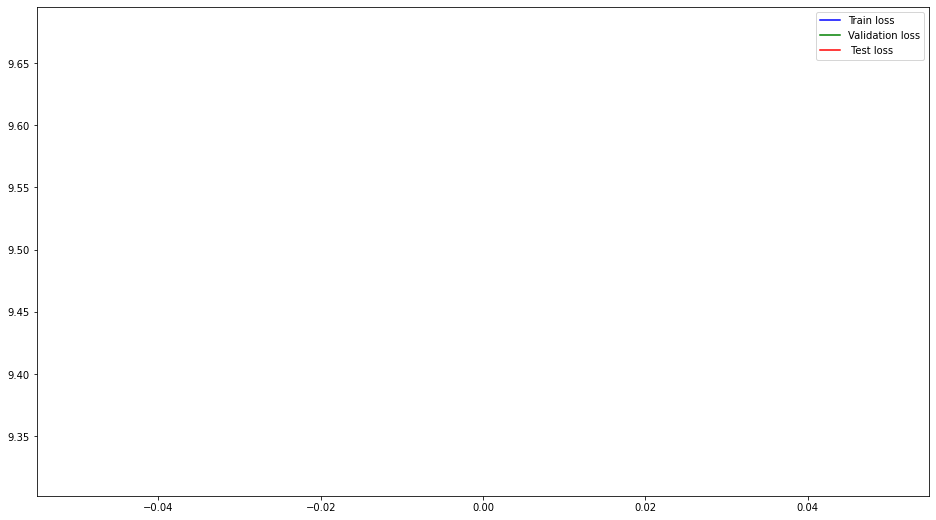

Эпоха =  1 RMSE= 9.401886940002441 
 Max_pred =  2010.0 Max_test =  2022.8373 
 Min_pred =  1927.0 Min_test =  1957.4243
Эпоха =  2


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

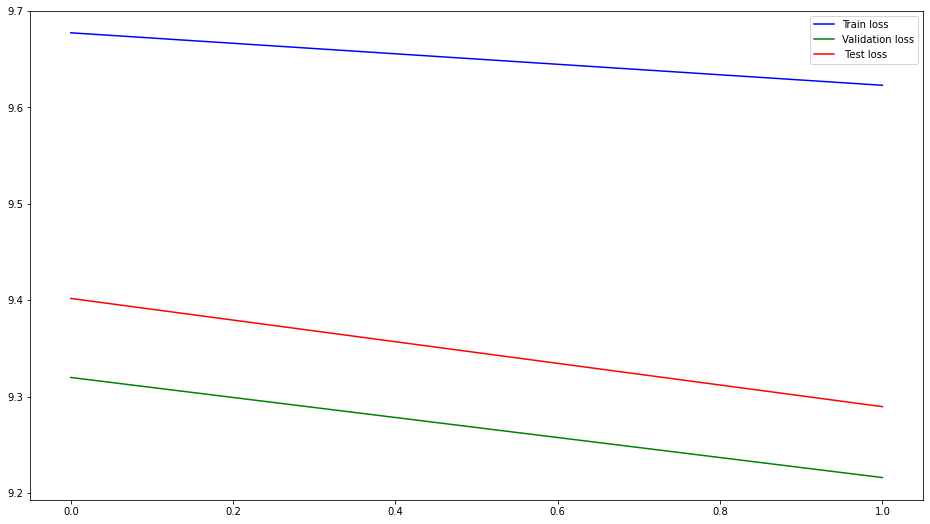

Эпоха =  2 RMSE= 9.289639472961426 
 Max_pred =  2010.0 Max_test =  2025.1201 
 Min_pred =  1927.0 Min_test =  1953.8123
Эпоха =  3


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

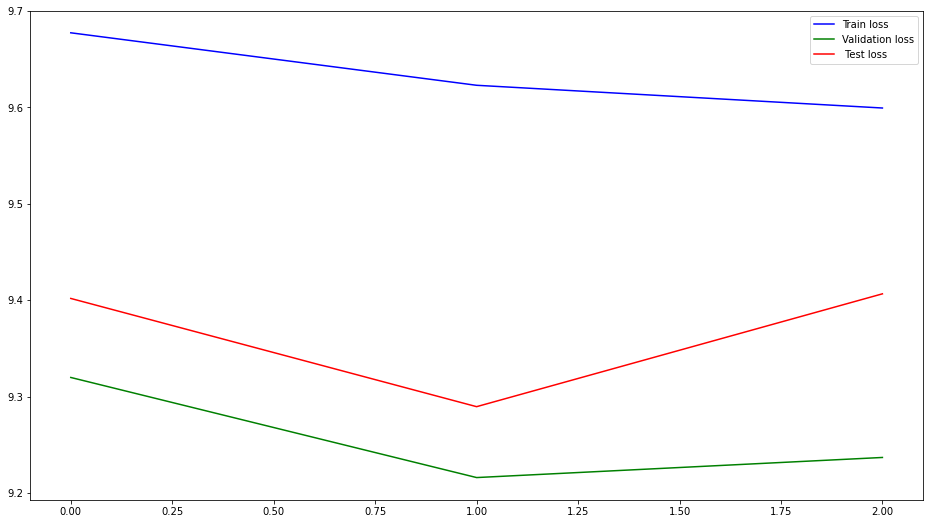

Эпоха =  3 RMSE= 9.406668663024902 
 Max_pred =  2010.0 Max_test =  2029.0188 
 Min_pred =  1927.0 Min_test =  1942.4838
Эпоха =  4


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

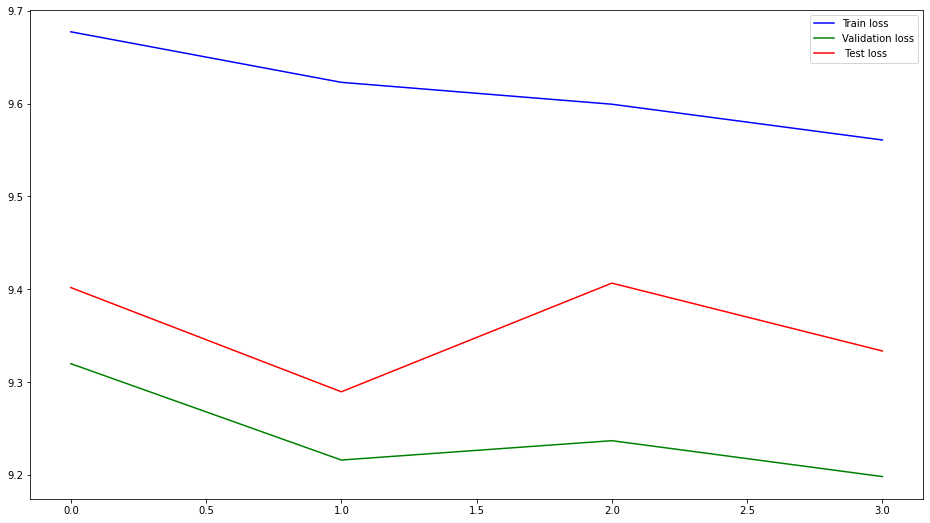

Эпоха =  4 RMSE= 9.333579063415527 
 Max_pred =  2010.0 Max_test =  2019.6696 
 Min_pred =  1927.0 Min_test =  1955.7786
Эпоха =  5


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

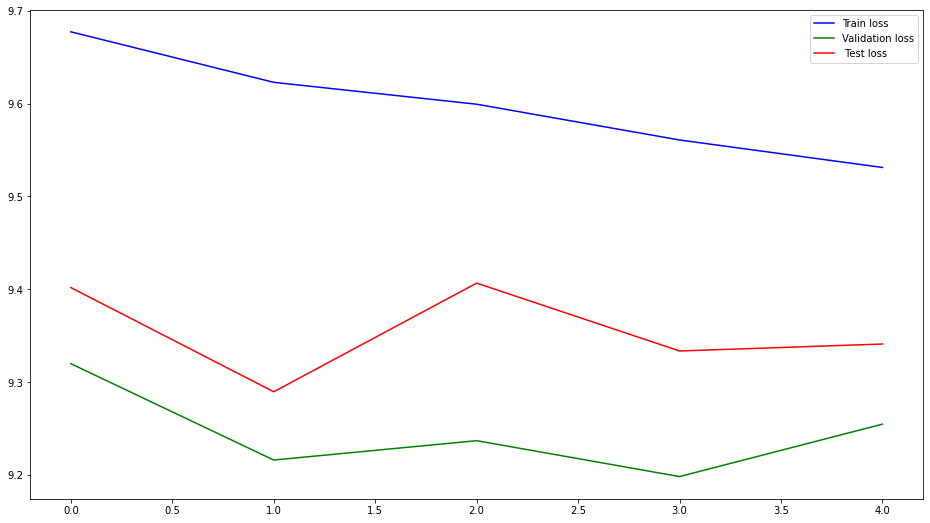

Эпоха =  5 RMSE= 9.341078758239746 
 Max_pred =  2010.0 Max_test =  2021.1705 
 Min_pred =  1927.0 Min_test =  1953.8496
Эпоха =  6


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

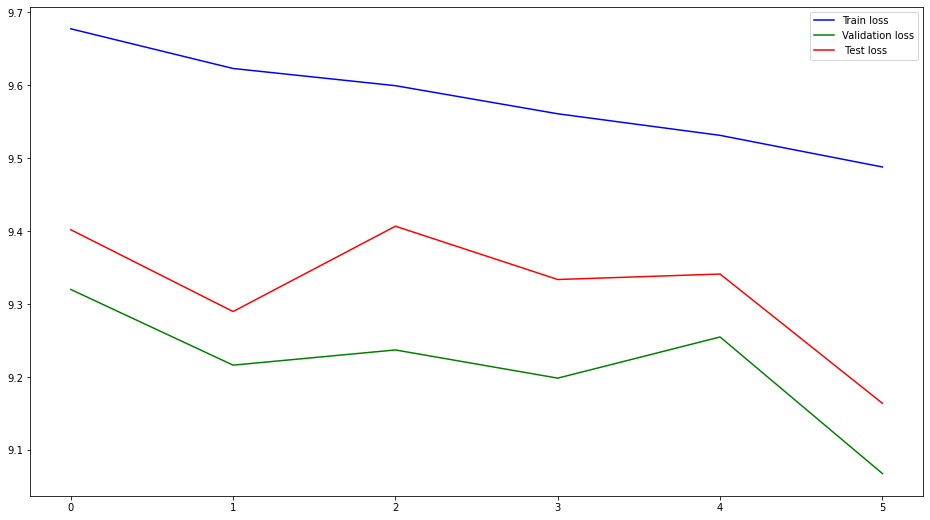

Эпоха =  6 RMSE= 9.16382122039795 
 Max_pred =  2010.0 Max_test =  2017.1854 
 Min_pred =  1927.0 Min_test =  1954.6047
Эпоха =  7


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

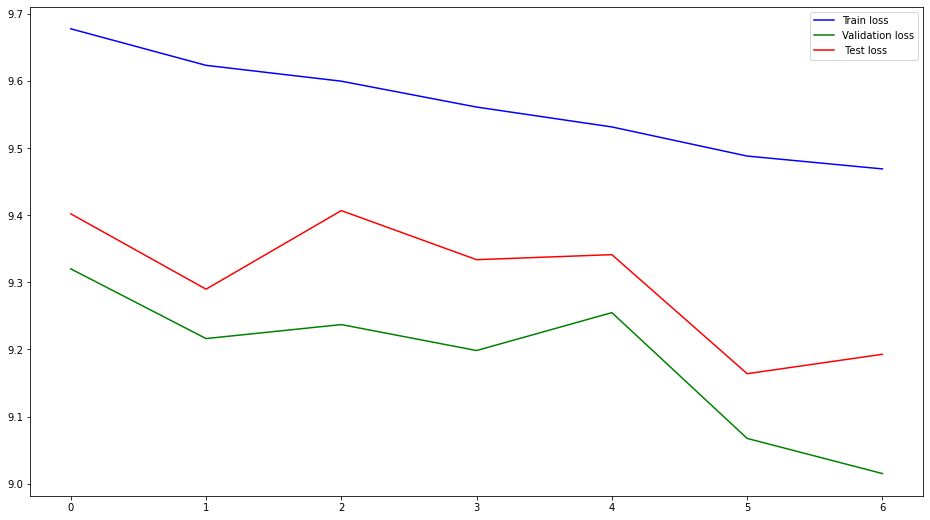

Эпоха =  7 RMSE= 9.192696571350098 
 Max_pred =  2010.0 Max_test =  2026.6006 
 Min_pred =  1927.0 Min_test =  1948.7898
Эпоха =  8


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

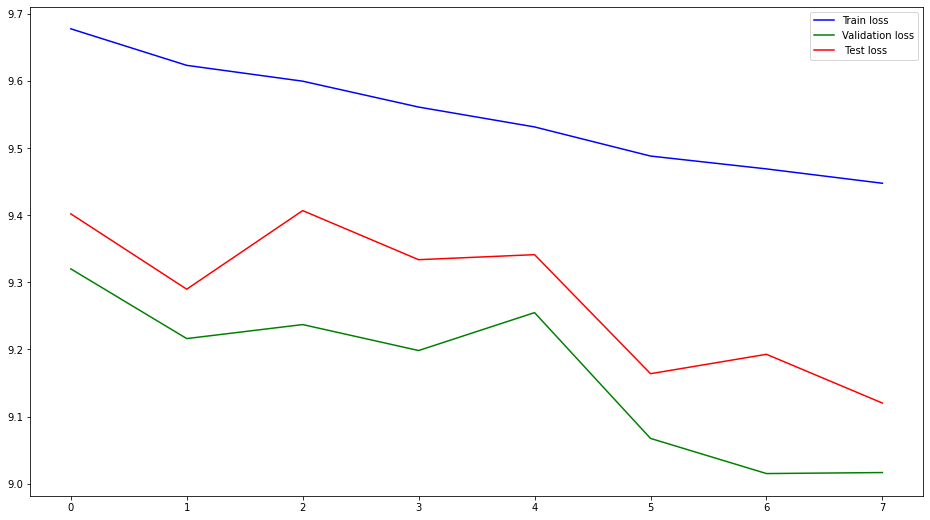

Эпоха =  8 RMSE= 9.120091438293457 
 Max_pred =  2010.0 Max_test =  2019.4027 
 Min_pred =  1927.0 Min_test =  1951.9741
Эпоха =  9


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

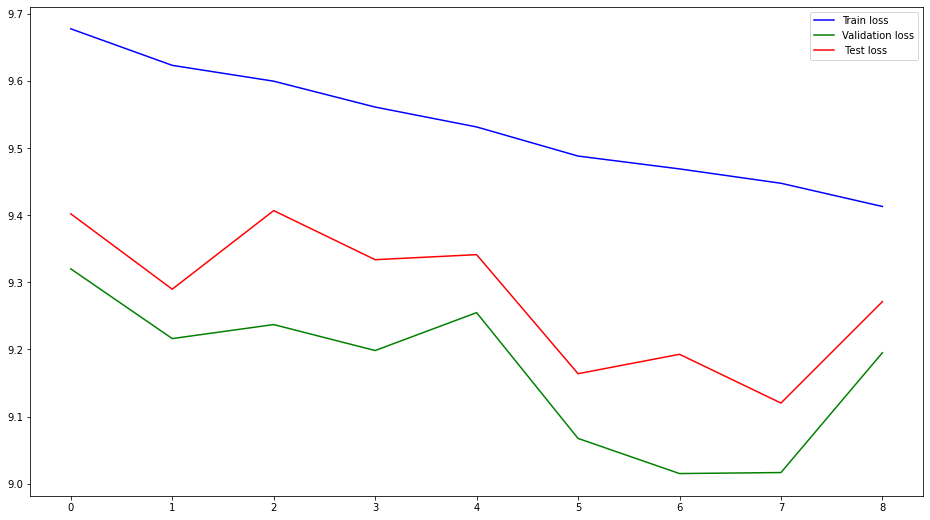

Эпоха =  9 RMSE= 9.27112865447998 
 Max_pred =  2010.0 Max_test =  2017.8729 
 Min_pred =  1927.0 Min_test =  1966.7078
Эпоха =  10


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

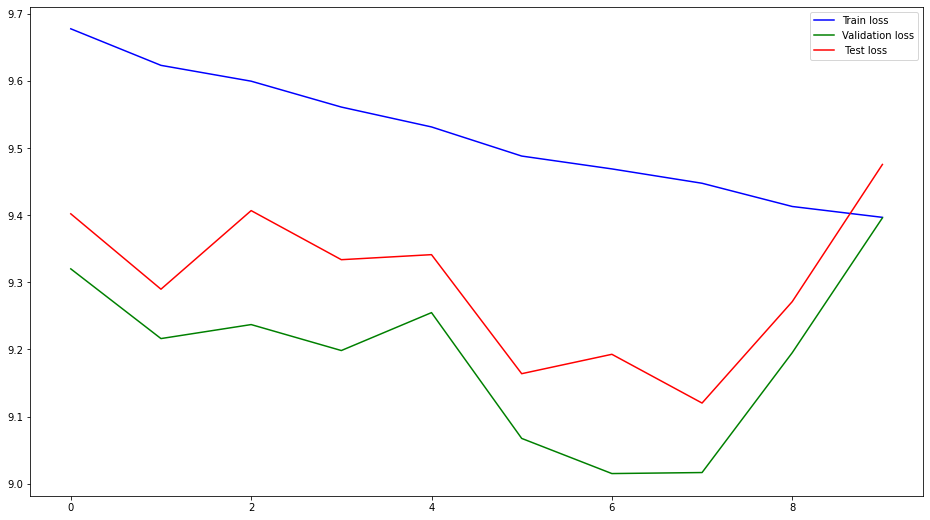

Эпоха =  10 RMSE= 9.475399017333984 
 Max_pred =  2010.0 Max_test =  2017.5459 
 Min_pred =  1927.0 Min_test =  1975.6661
Эпоха =  11


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

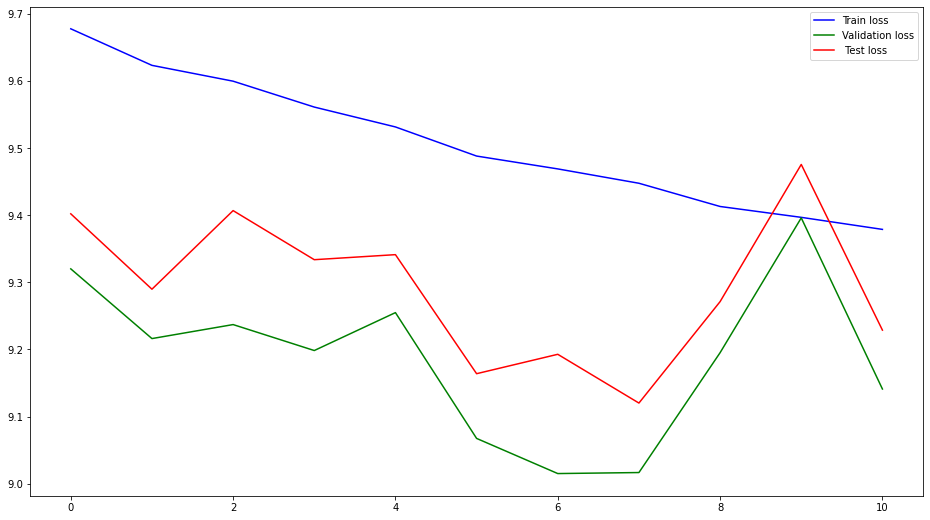

Эпоха =  11 RMSE= 9.2287015914917 
 Max_pred =  2010.0 Max_test =  2009.6527 
 Min_pred =  1927.0 Min_test =  1955.3944
Эпоха =  12


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

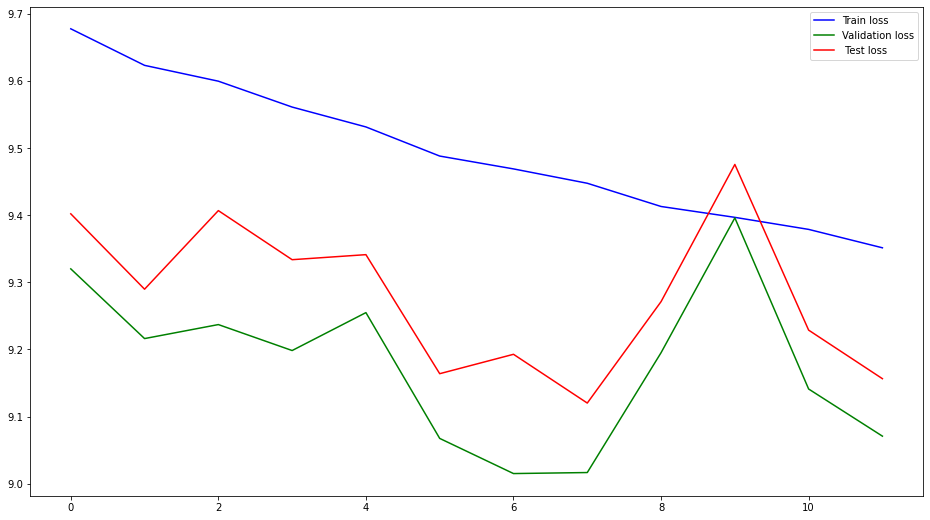

Эпоха =  12 RMSE= 9.156373977661133 
 Max_pred =  2010.0 Max_test =  2016.7574 
 Min_pred =  1927.0 Min_test =  1970.9093
Эпоха =  13


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

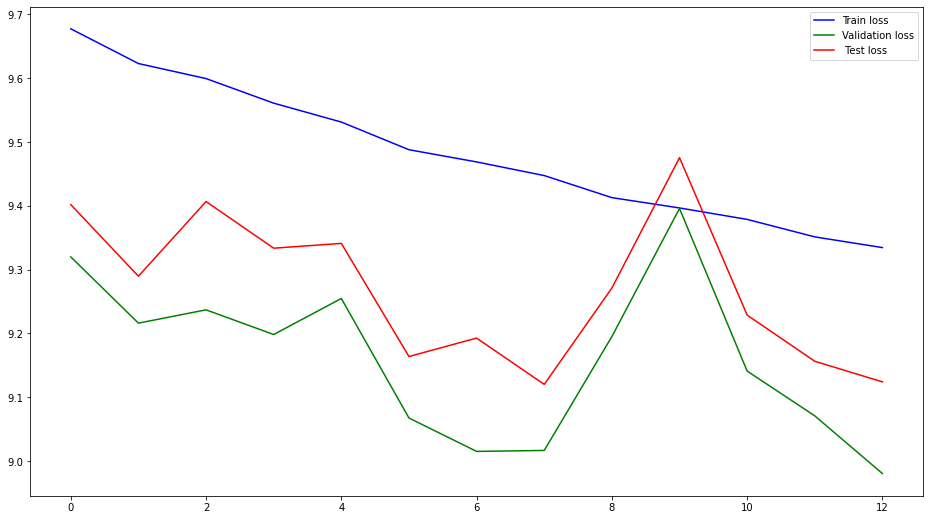

Эпоха =  13 RMSE= 9.124115943908691 
 Max_pred =  2010.0 Max_test =  2016.1372 
 Min_pred =  1927.0 Min_test =  1962.1927
Эпоха =  14


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

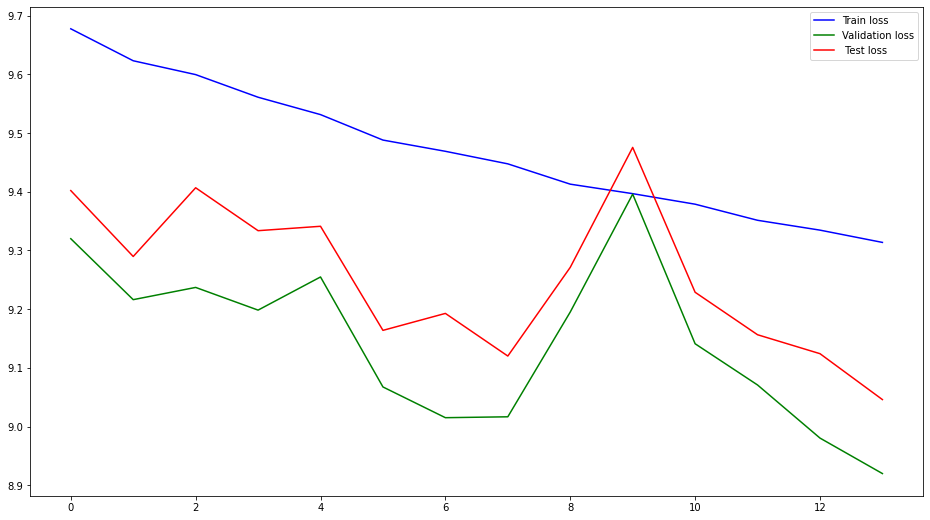

Эпоха =  14 RMSE= 9.045936584472656 
 Max_pred =  2010.0 Max_test =  2015.9187 
 Min_pred =  1927.0 Min_test =  1964.6649
Эпоха =  15


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

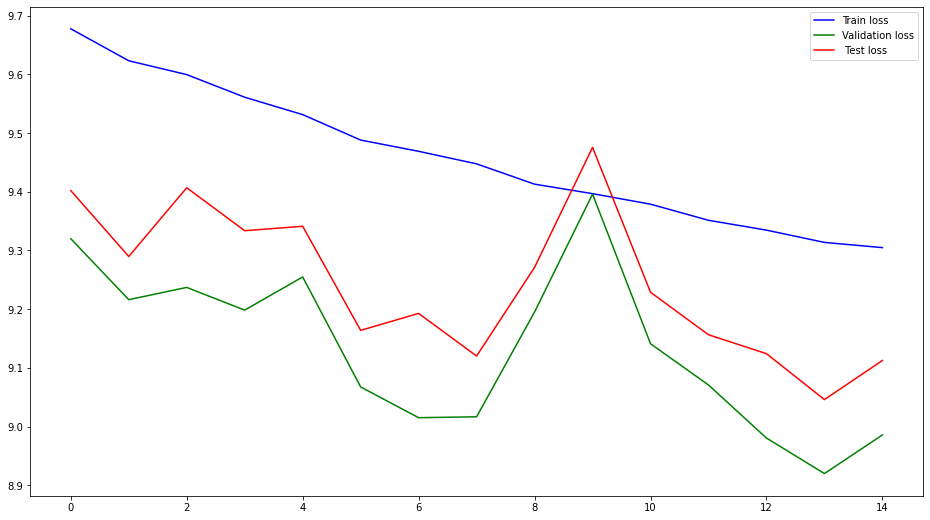

Эпоха =  15 RMSE= 9.112513542175293 
 Max_pred =  2010.0 Max_test =  2014.8726 
 Min_pred =  1927.0 Min_test =  1963.0062
Эпоха =  16


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

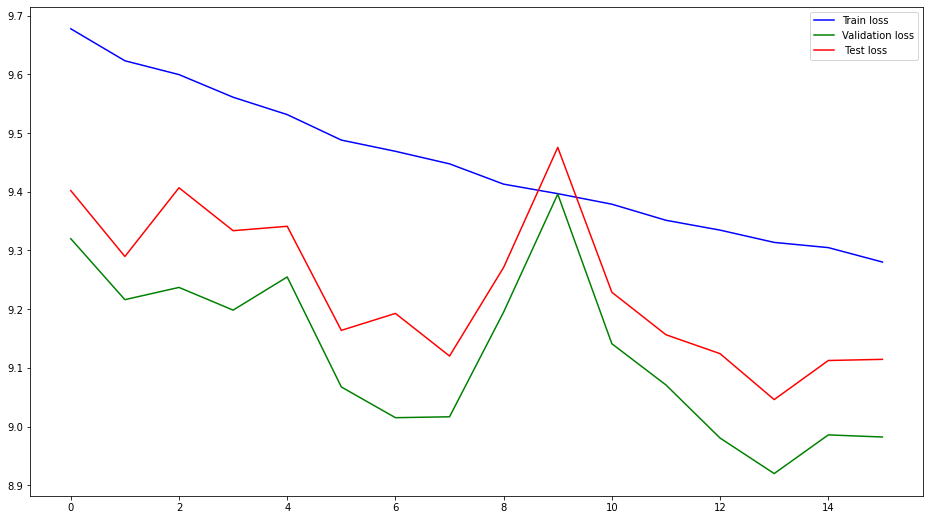

Эпоха =  16 RMSE= 9.114441871643066 
 Max_pred =  2010.0 Max_test =  2016.8097 
 Min_pred =  1927.0 Min_test =  1963.6279
Эпоха =  17


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

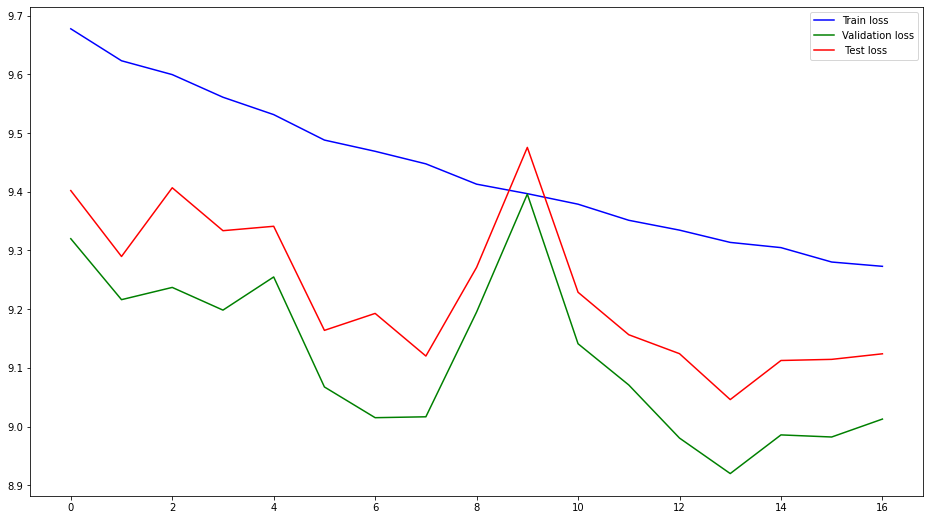

Эпоха =  17 RMSE= 9.123912811279297 
 Max_pred =  2010.0 Max_test =  2013.4897 
 Min_pred =  1927.0 Min_test =  1972.2251
Эпоха =  18


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

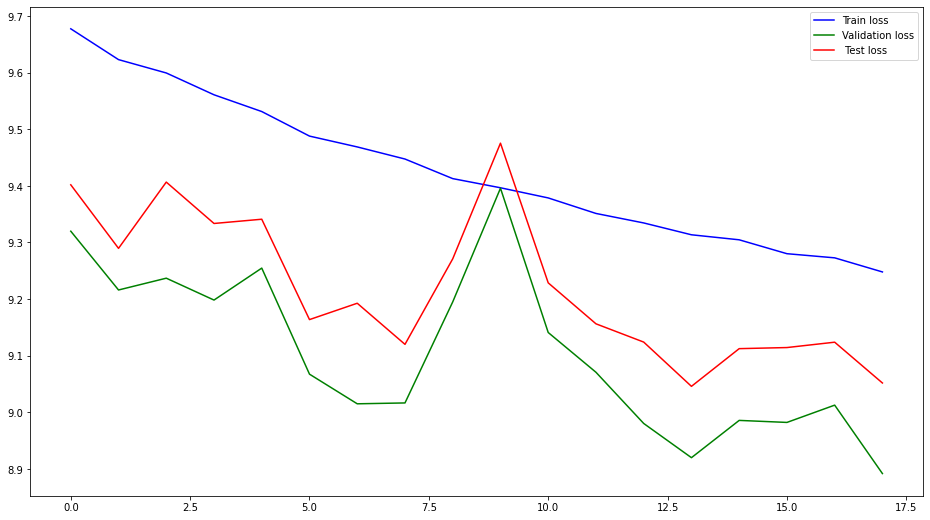

Эпоха =  18 RMSE= 9.051855087280273 
 Max_pred =  2010.0 Max_test =  2015.729 
 Min_pred =  1927.0 Min_test =  1965.0642
Эпоха =  19


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

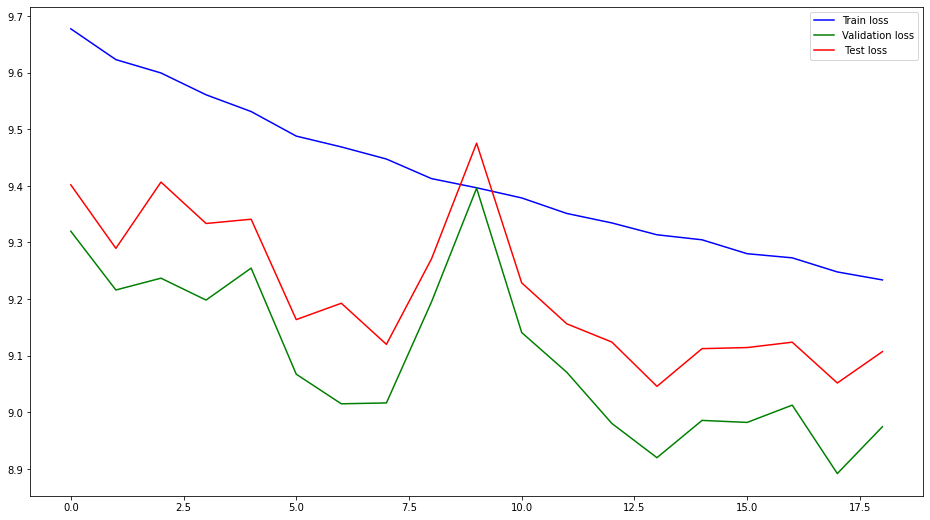

Эпоха =  19 RMSE= 9.107280731201172 
 Max_pred =  2010.0 Max_test =  2013.0197 
 Min_pred =  1927.0 Min_test =  1968.1932
Эпоха =  20


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

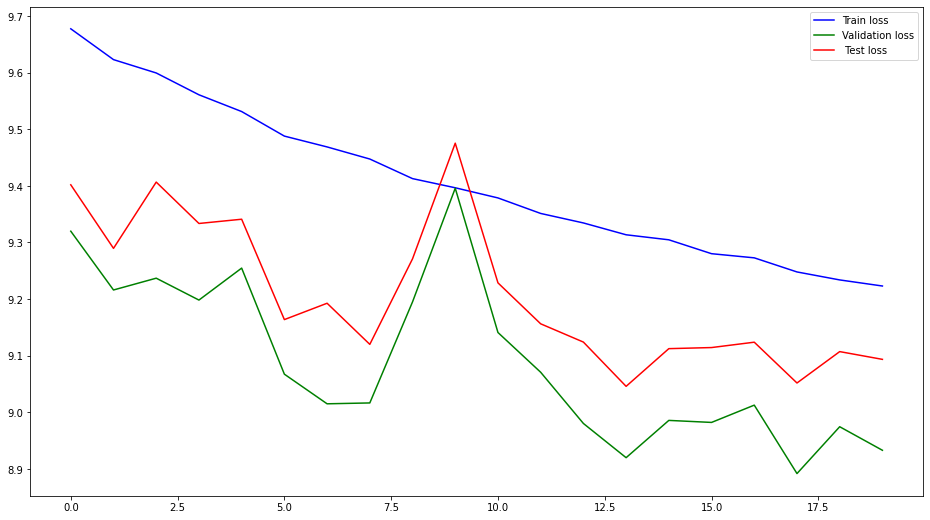

Эпоха =  20 RMSE= 9.093595504760742 
 Max_pred =  2010.0 Max_test =  2013.4674 
 Min_pred =  1927.0 Min_test =  1963.5798
Эпоха =  21


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

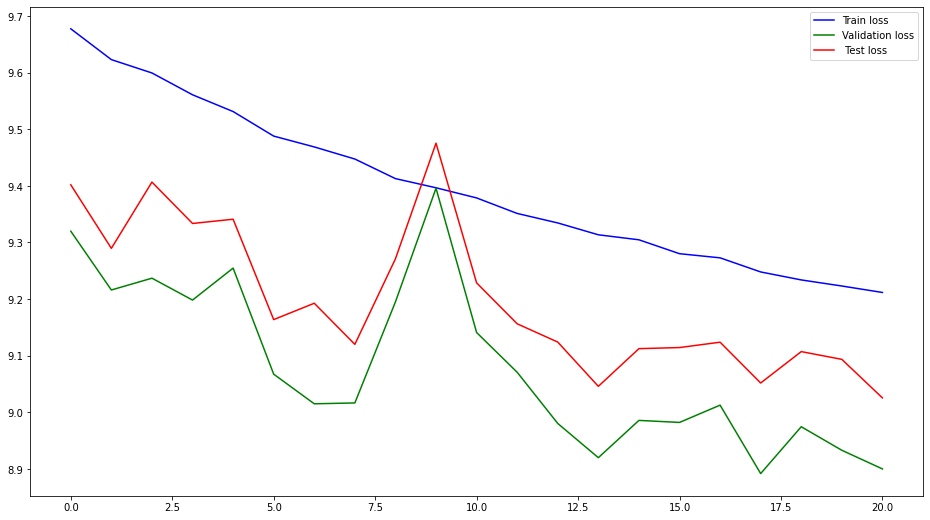

Эпоха =  21 RMSE= 9.02552604675293 
 Max_pred =  2010.0 Max_test =  2015.5735 
 Min_pred =  1927.0 Min_test =  1967.2046
Эпоха =  22


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

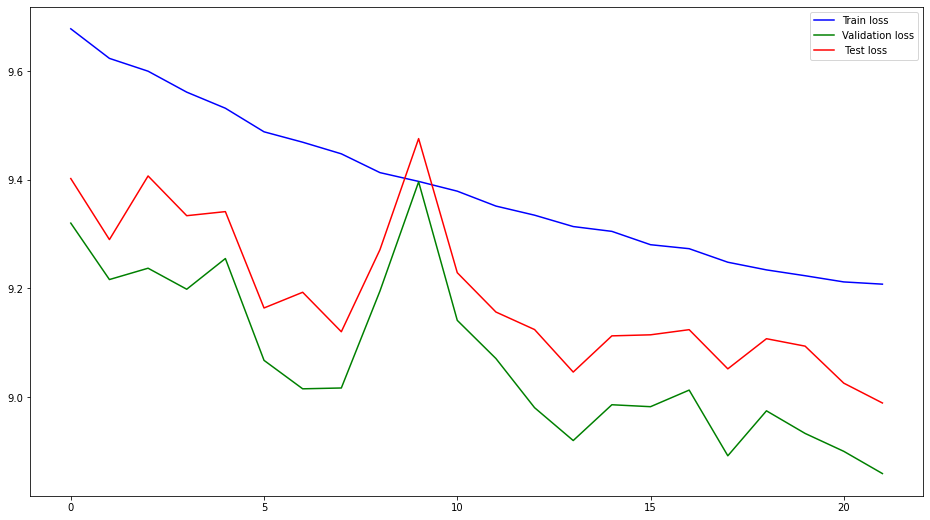

Эпоха =  22 RMSE= 8.989029884338379 
 Max_pred =  2010.0 Max_test =  2013.9751 
 Min_pred =  1927.0 Min_test =  1968.1781
Эпоха =  23


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

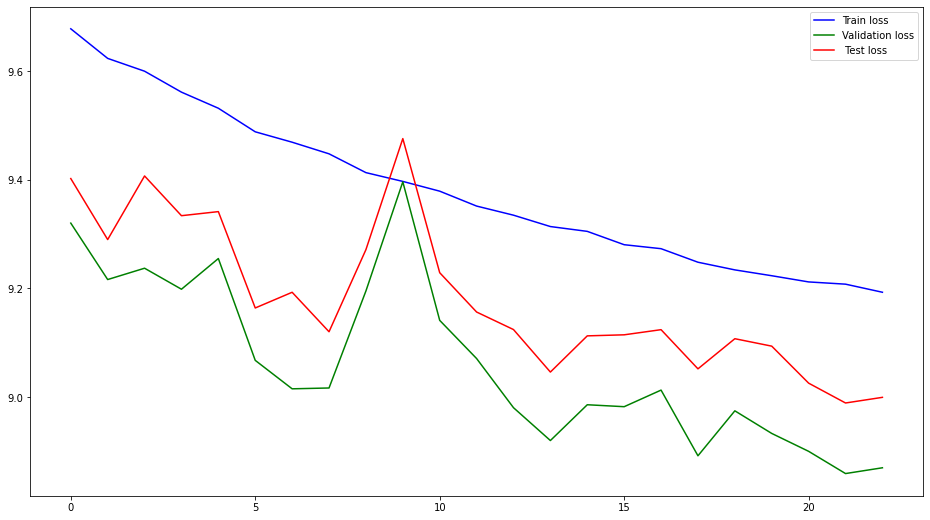

Эпоха =  23 RMSE= 8.999419212341309 
 Max_pred =  2010.0 Max_test =  2012.5918 
 Min_pred =  1927.0 Min_test =  1973.1843
Эпоха =  24


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

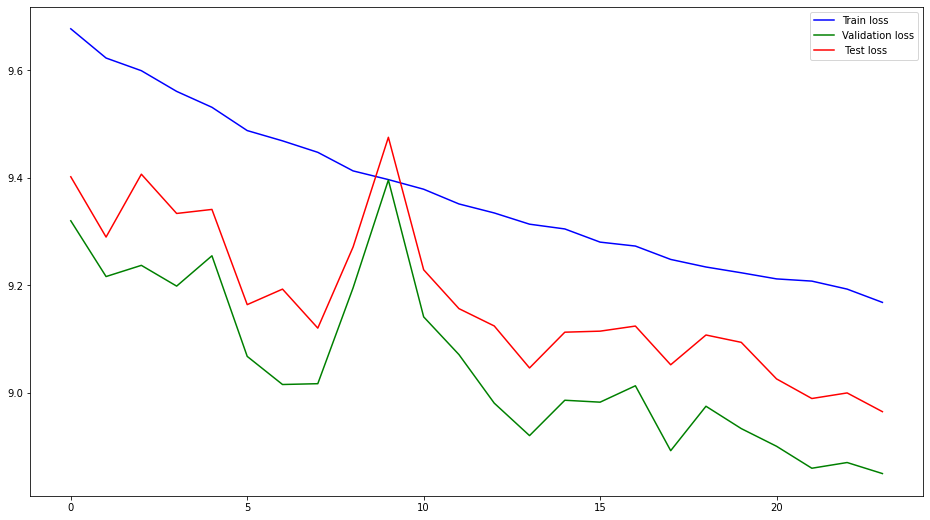

Эпоха =  24 RMSE= 8.96452808380127 
 Max_pred =  2010.0 Max_test =  2015.8492 
 Min_pred =  1927.0 Min_test =  1969.1146
Эпоха =  25


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

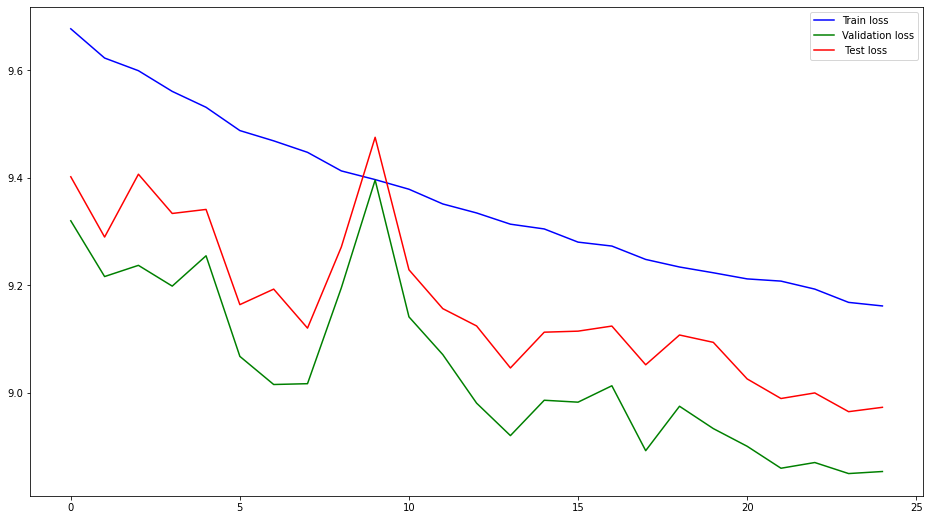

Эпоха =  25 RMSE= 8.972643852233887 
 Max_pred =  2010.0 Max_test =  2019.2358 
 Min_pred =  1927.0 Min_test =  1969.939
Эпоха =  26


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

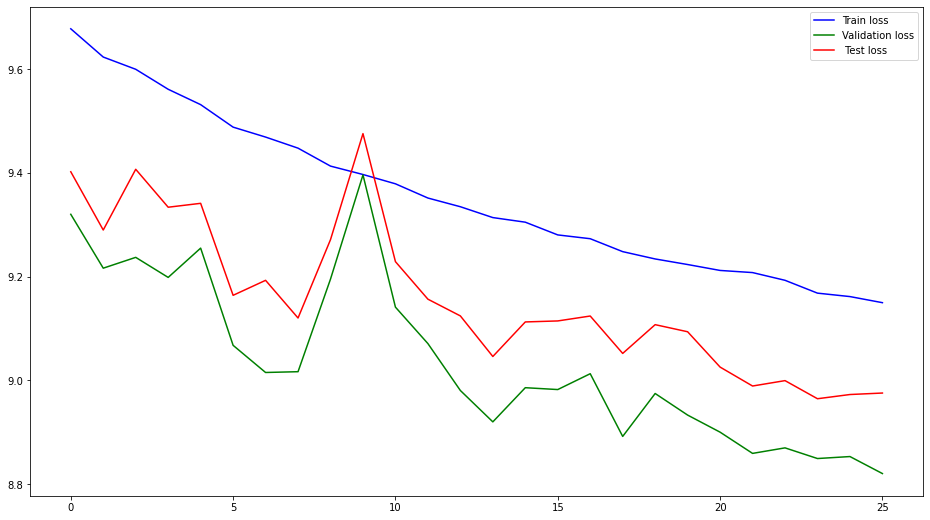

Эпоха =  26 RMSE= 8.975502014160156 
 Max_pred =  2010.0 Max_test =  2013.2753 
 Min_pred =  1927.0 Min_test =  1967.8612
Эпоха =  27


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

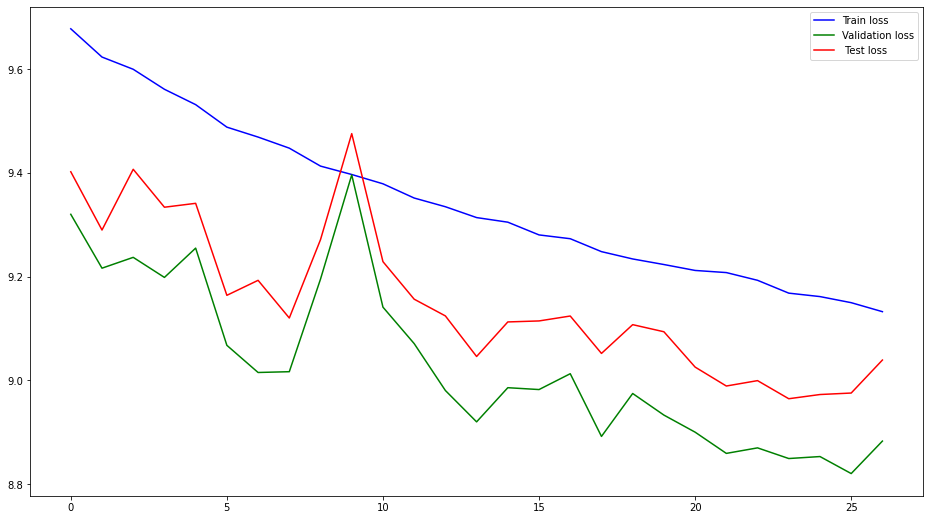

Эпоха =  27 RMSE= 9.039107322692871 
 Max_pred =  2010.0 Max_test =  2015.228 
 Min_pred =  1927.0 Min_test =  1975.0919
Эпоха =  28


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

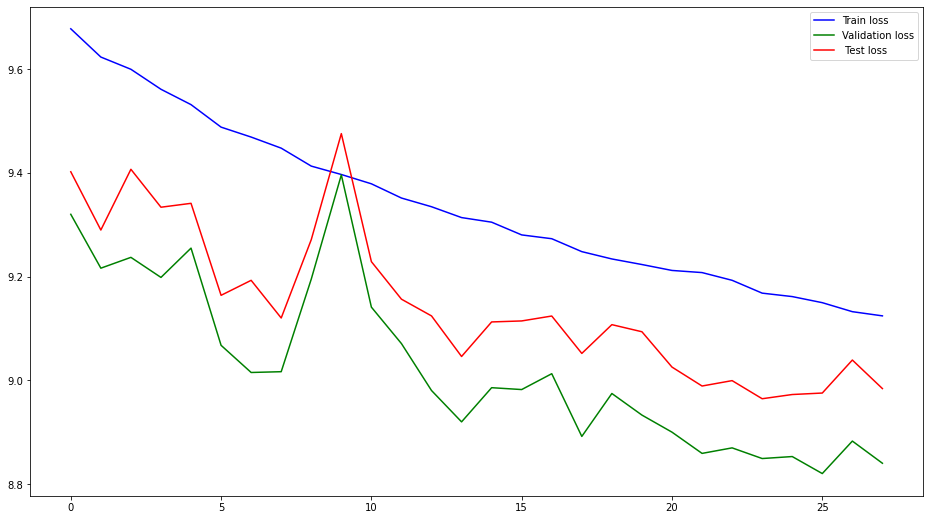

Эпоха =  28 RMSE= 8.98408317565918 
 Max_pred =  2010.0 Max_test =  2015.5181 
 Min_pred =  1927.0 Min_test =  1969.7451
Эпоха =  29


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

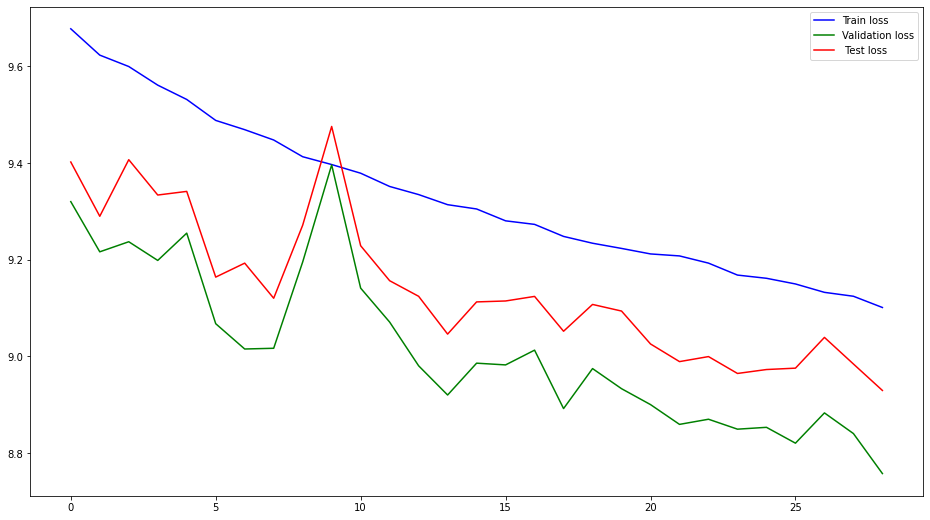

Эпоха =  29 RMSE= 8.929346084594727 
 Max_pred =  2010.0 Max_test =  2014.3851 
 Min_pred =  1927.0 Min_test =  1968.6837
Эпоха =  30


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

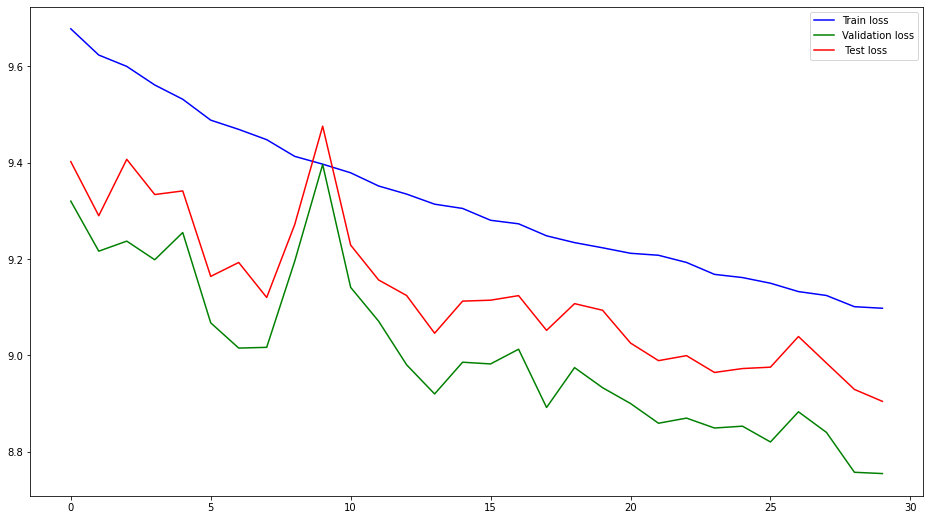

Эпоха =  30 RMSE= 8.904573440551758 
 Max_pred =  2010.0 Max_test =  2018.6177 
 Min_pred =  1927.0 Min_test =  1966.7104


In [86]:
trloss = []
valloss = []
teloss = []
epoch_ar = []
for epoch in range(epoches):
    print("Эпоха = ", epoch +1)
    epoch_ar.append(epoch)
    a= train(model, optimizer, criterion, train_loader)
    b = val(model, optimizer, criterion, val_loader)
    scheduler.step()
    trloss.append(a)
    valloss.append(b)
    t,predict, c =  test(model, criterion, test_loader)
    teloss.append(c)
    if clear:
        clear_output()
    plt.figure(figsize = (16,9))
    plt.plot(epoch_ar,trloss,color = 'blue',label = "Train loss")
    plt.plot(epoch_ar,valloss,color = 'green',label = "Validation loss")
    plt.plot(epoch_ar,teloss,color = 'red',label = " Test loss")
    plt.legend()
    plt.show()
    
    print("Эпоха = ", epoch +1,"RMSE=",float(teloss[-1]),"\n",
                 "Max_pred = ",np.max(predict),"Max_test = ",np.max(t),"\n",
                  "Min_pred = ",np.min(predict),"Min_test = ",np.min(t))

Эпоха =  30


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

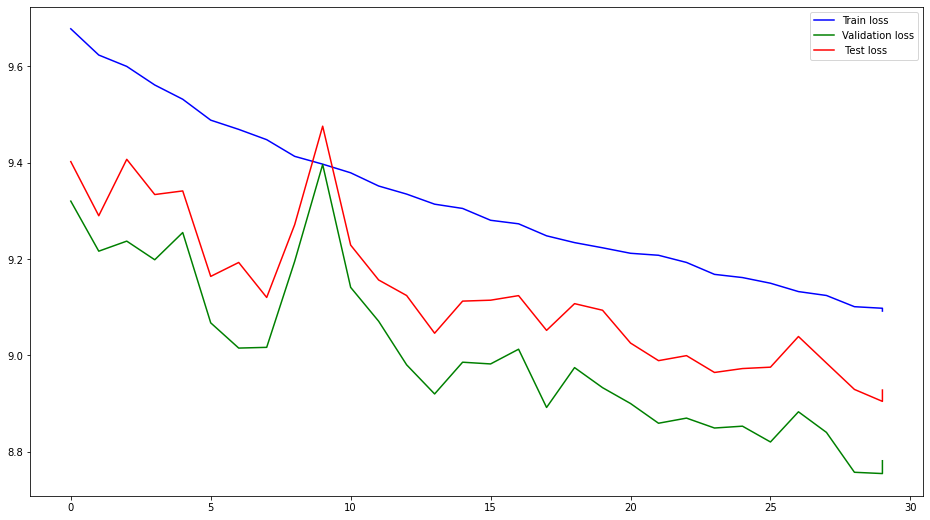

Эпоха =  30 RMSE= 8.928088188171387 
 Max_pred =  2010.0 Max_test =  2014.26 
 Min_pred =  1927.0 Min_test =  1972.5686
Эпоха =  31


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

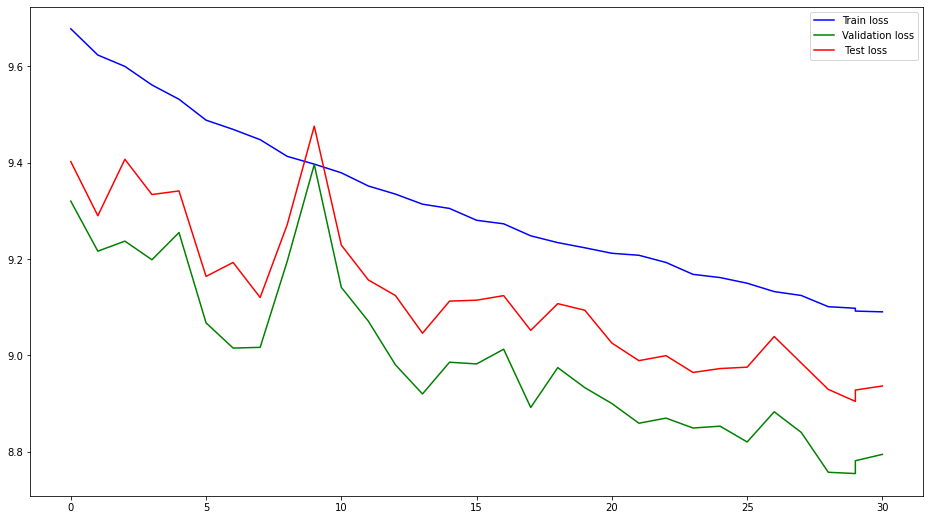

Эпоха =  31 RMSE= 8.936485290527344 
 Max_pred =  2010.0 Max_test =  2017.6898 
 Min_pred =  1927.0 Min_test =  1976.7374
Эпоха =  32


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

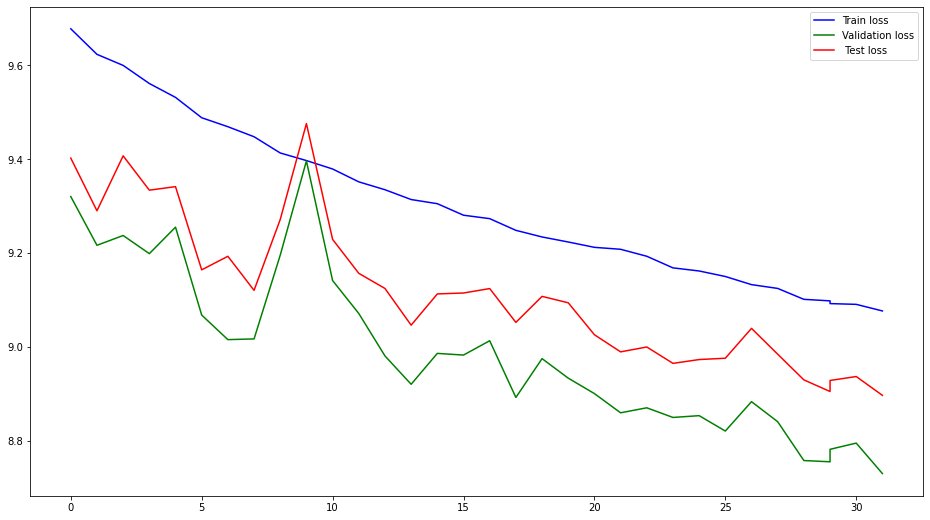

Эпоха =  32 RMSE= 8.896363258361816 
 Max_pred =  2010.0 Max_test =  2015.1179 
 Min_pred =  1927.0 Min_test =  1968.6224
Эпоха =  33


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

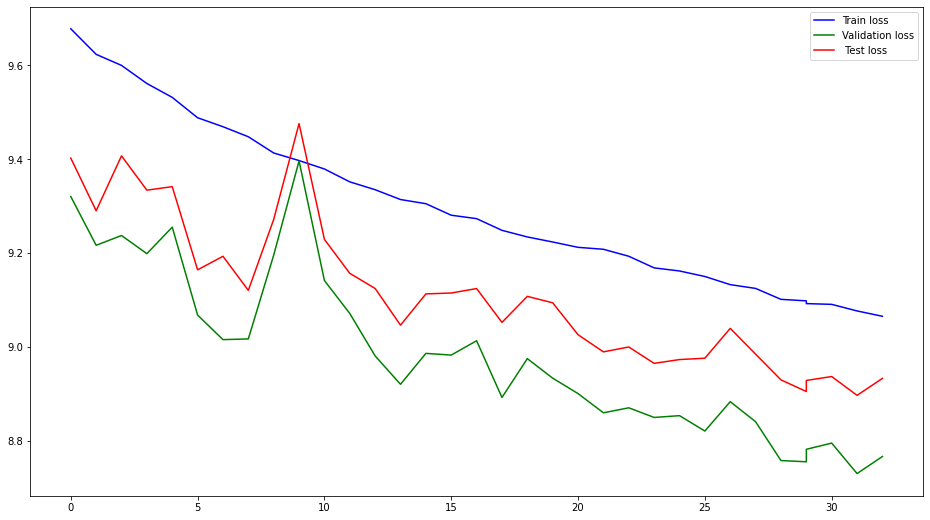

Эпоха =  33 RMSE= 8.932472229003906 
 Max_pred =  2010.0 Max_test =  2012.4999 
 Min_pred =  1927.0 Min_test =  1973.566
Эпоха =  34


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

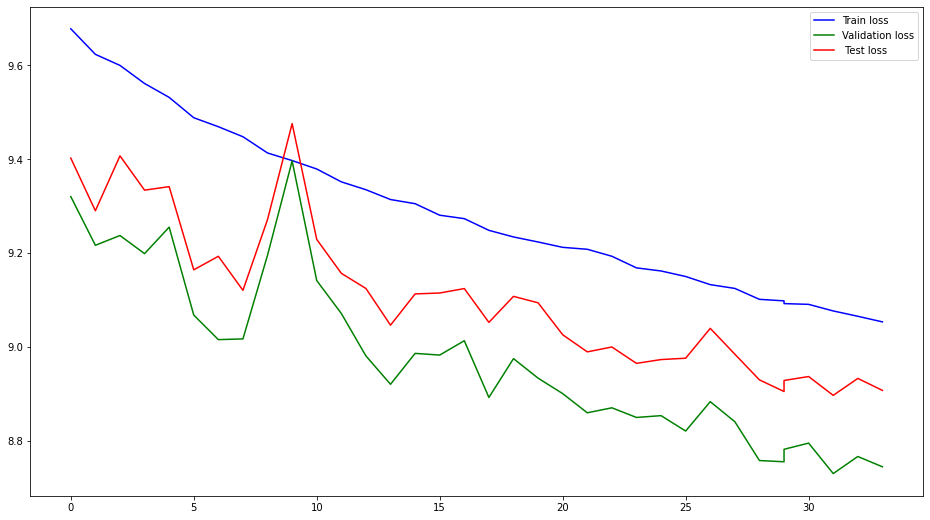

Эпоха =  34 RMSE= 8.906949996948242 
 Max_pred =  2010.0 Max_test =  2012.4999 
 Min_pred =  1927.0 Min_test =  1970.7213
Эпоха =  35


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

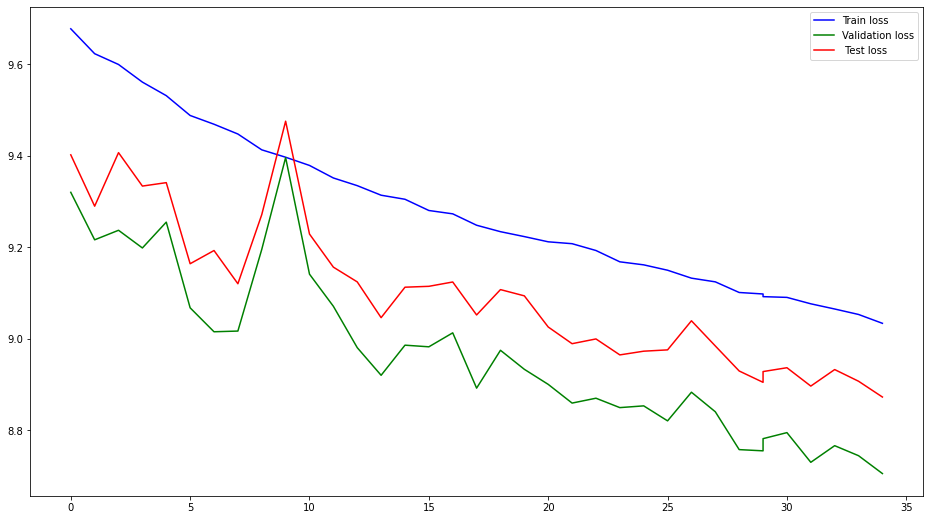

Эпоха =  35 RMSE= 8.872429847717285 
 Max_pred =  2010.0 Max_test =  2015.0784 
 Min_pred =  1927.0 Min_test =  1970.9698
Эпоха =  36


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

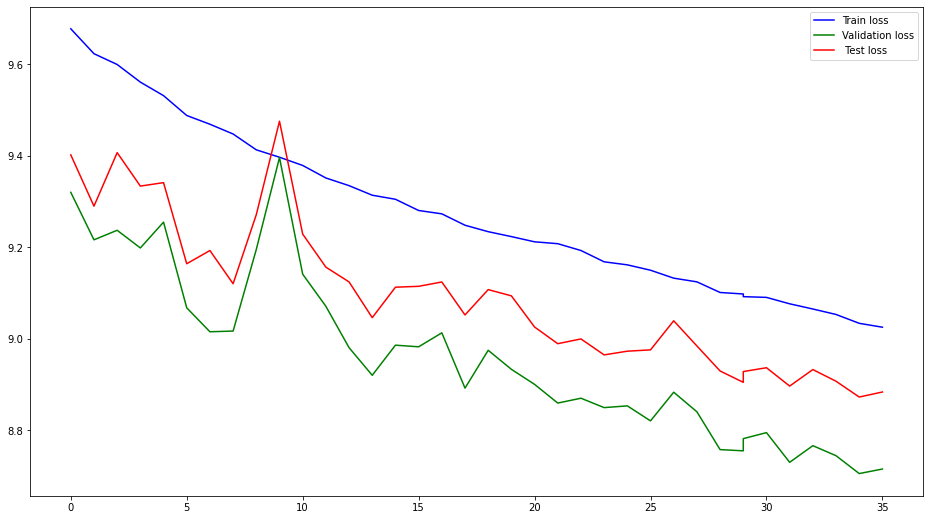

Эпоха =  36 RMSE= 8.883459091186523 
 Max_pred =  2010.0 Max_test =  2012.7822 
 Min_pred =  1927.0 Min_test =  1972.776
Эпоха =  37


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

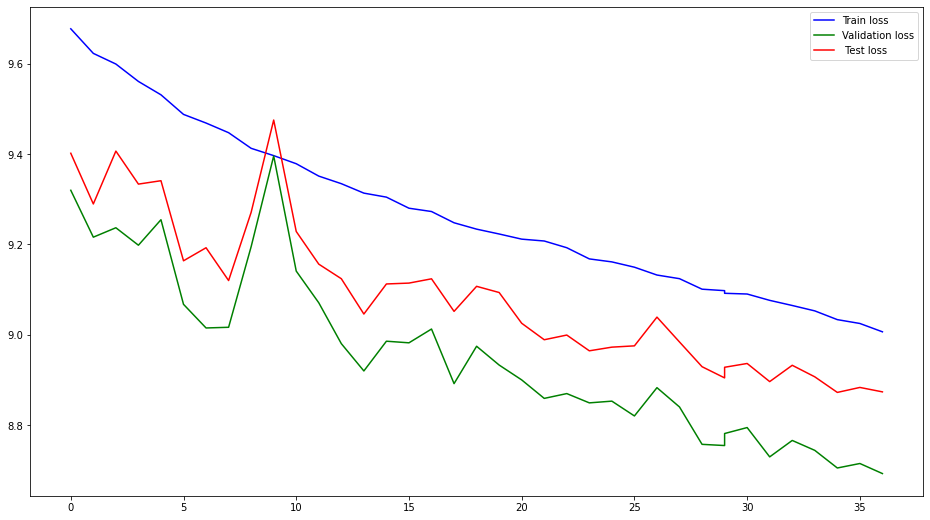

Эпоха =  37 RMSE= 8.87364673614502 
 Max_pred =  2010.0 Max_test =  2014.4669 
 Min_pred =  1927.0 Min_test =  1973.7668
Эпоха =  38


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

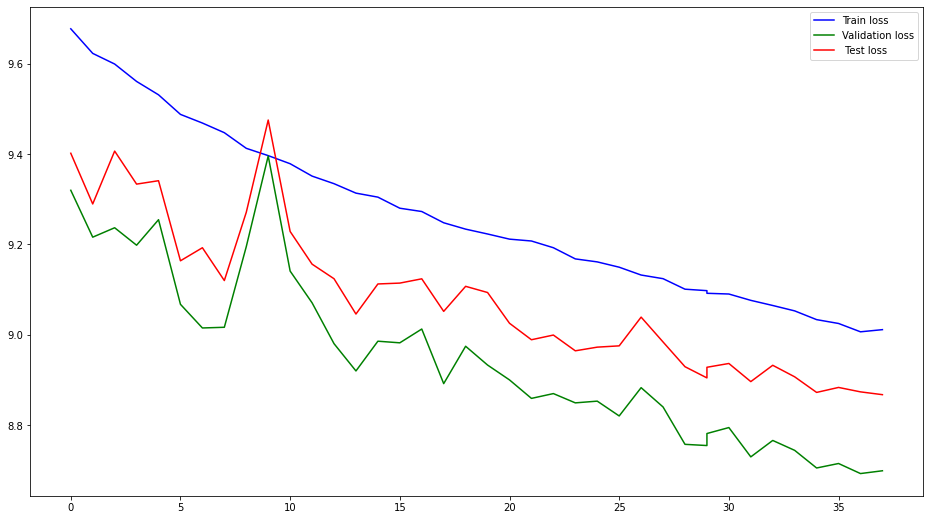

Эпоха =  38 RMSE= 8.867440223693848 
 Max_pred =  2010.0 Max_test =  2013.5074 
 Min_pred =  1927.0 Min_test =  1969.6588
Эпоха =  39


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

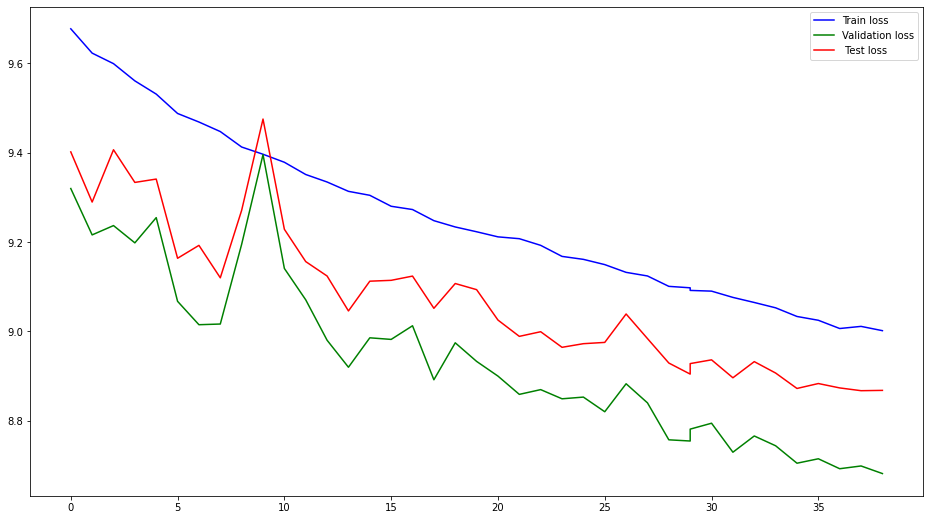

Эпоха =  39 RMSE= 8.868135452270508 
 Max_pred =  2010.0 Max_test =  2012.4263 
 Min_pred =  1927.0 Min_test =  1975.2872
Эпоха =  40


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

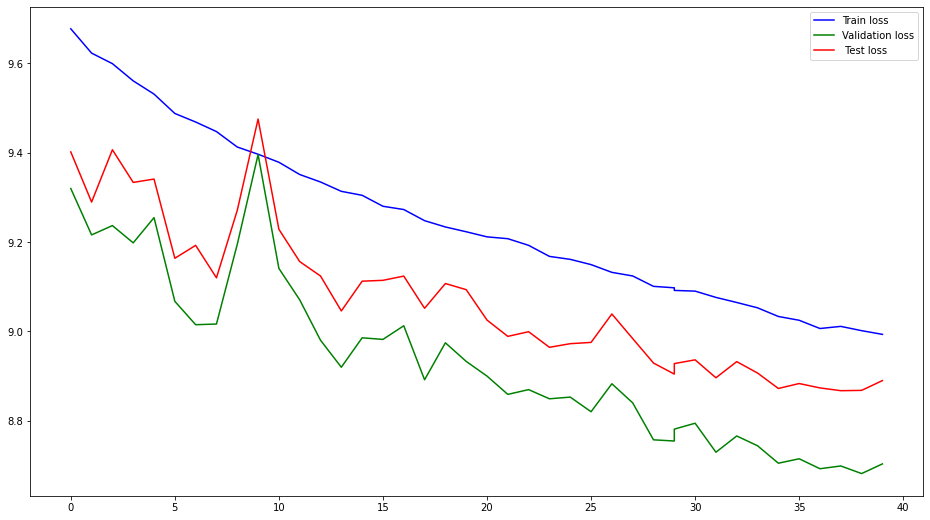

Эпоха =  40 RMSE= 8.890044212341309 
 Max_pred =  2010.0 Max_test =  2009.9967 
 Min_pred =  1927.0 Min_test =  1977.6013
Эпоха =  41


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

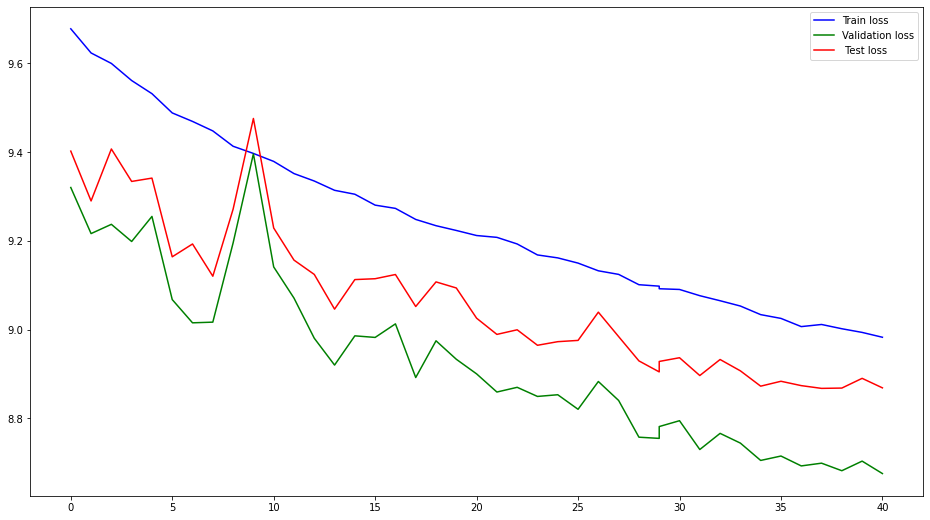

Эпоха =  41 RMSE= 8.868611335754395 
 Max_pred =  2010.0 Max_test =  2013.4476 
 Min_pred =  1927.0 Min_test =  1974.6189
Эпоха =  42


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

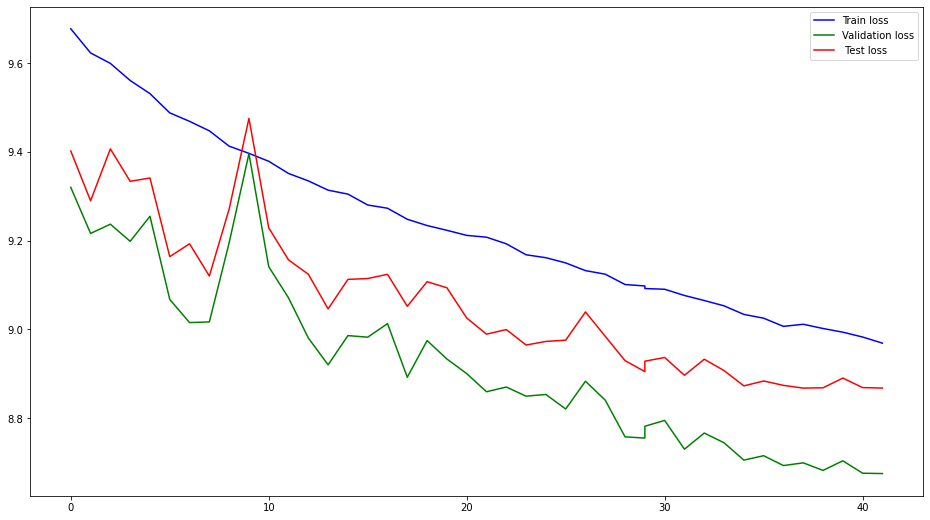

Эпоха =  42 RMSE= 8.8674955368042 
 Max_pred =  2010.0 Max_test =  2010.133 
 Min_pred =  1927.0 Min_test =  1975.8956
Эпоха =  43


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

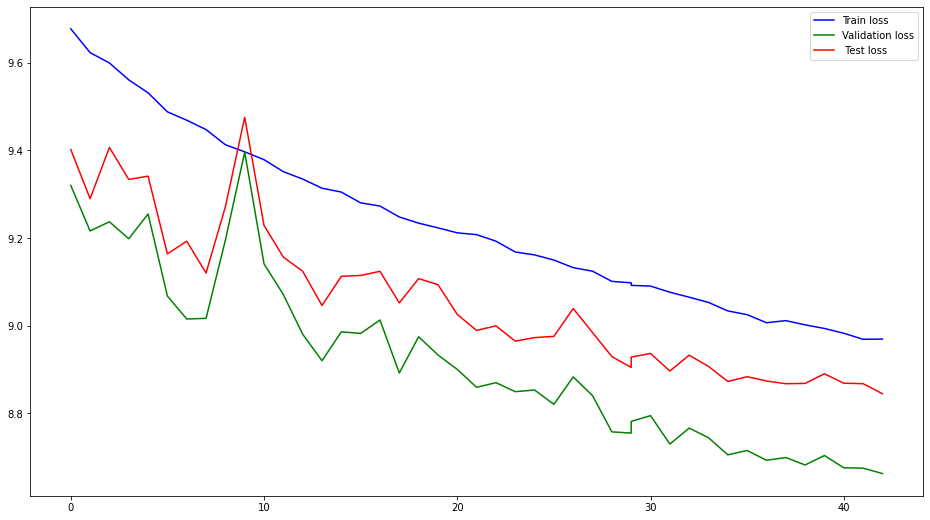

Эпоха =  43 RMSE= 8.844545364379883 
 Max_pred =  2010.0 Max_test =  2012.9717 
 Min_pred =  1927.0 Min_test =  1973.7797
Эпоха =  44


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

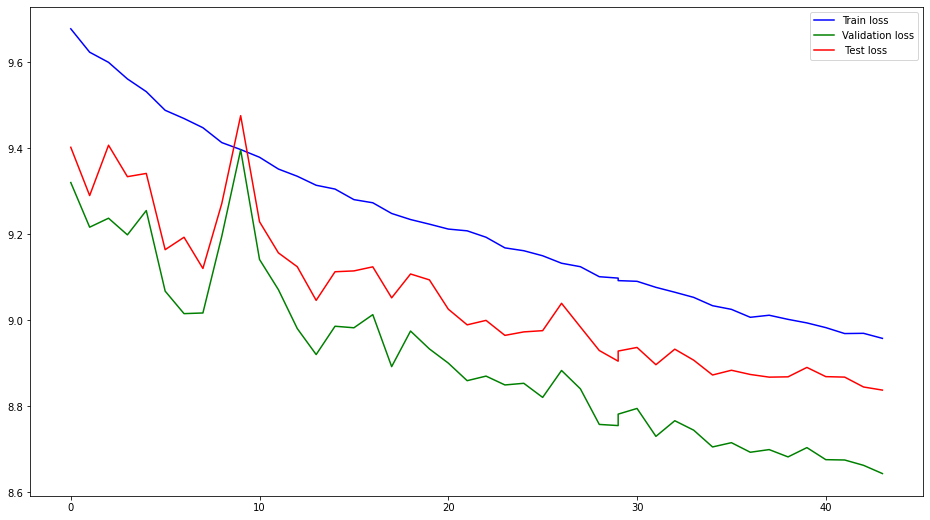

Эпоха =  44 RMSE= 8.837307929992676 
 Max_pred =  2010.0 Max_test =  2011.8457 
 Min_pred =  1927.0 Min_test =  1974.6246
Эпоха =  45


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

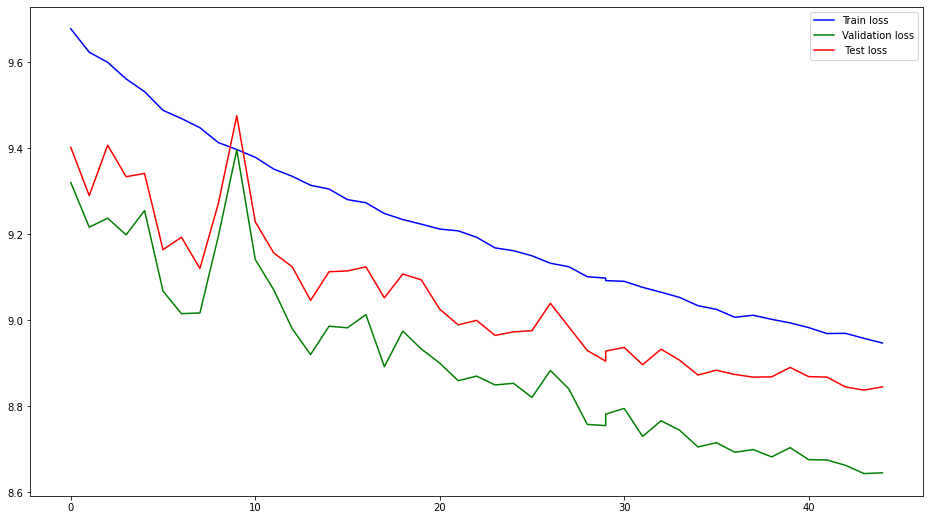

Эпоха =  45 RMSE= 8.844714164733887 
 Max_pred =  2010.0 Max_test =  2011.5581 
 Min_pred =  1927.0 Min_test =  1976.7366
Эпоха =  46


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

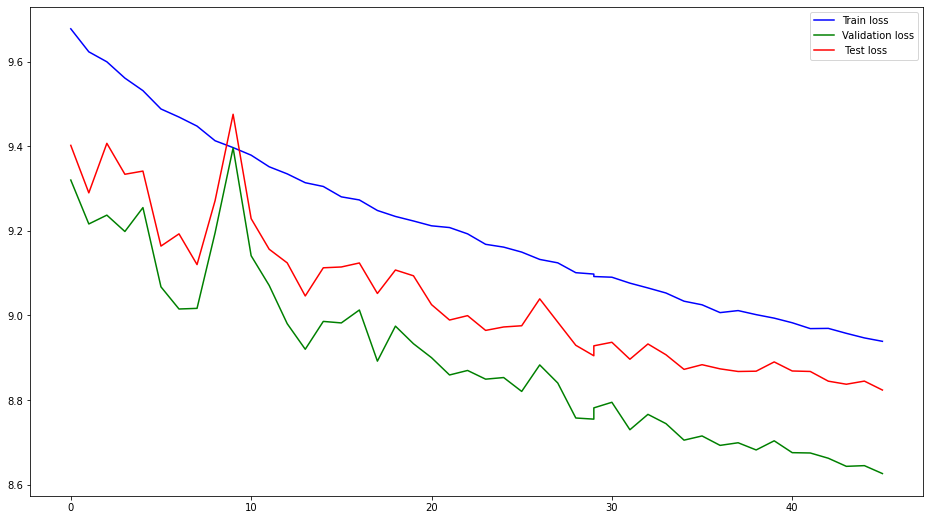

Эпоха =  46 RMSE= 8.823585510253906 
 Max_pred =  2010.0 Max_test =  2013.2585 
 Min_pred =  1927.0 Min_test =  1973.3765
Эпоха =  47


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

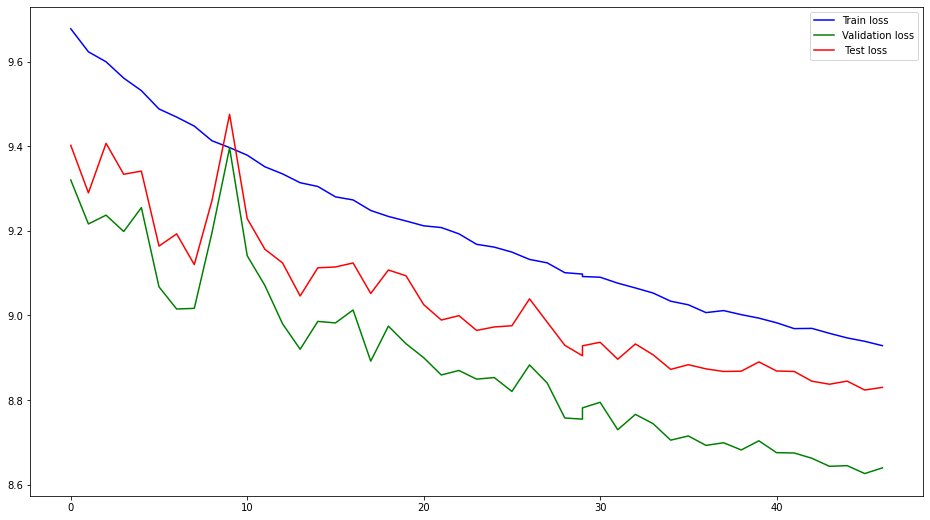

Эпоха =  47 RMSE= 8.829861640930176 
 Max_pred =  2010.0 Max_test =  2011.1263 
 Min_pred =  1927.0 Min_test =  1974.315
Эпоха =  48


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

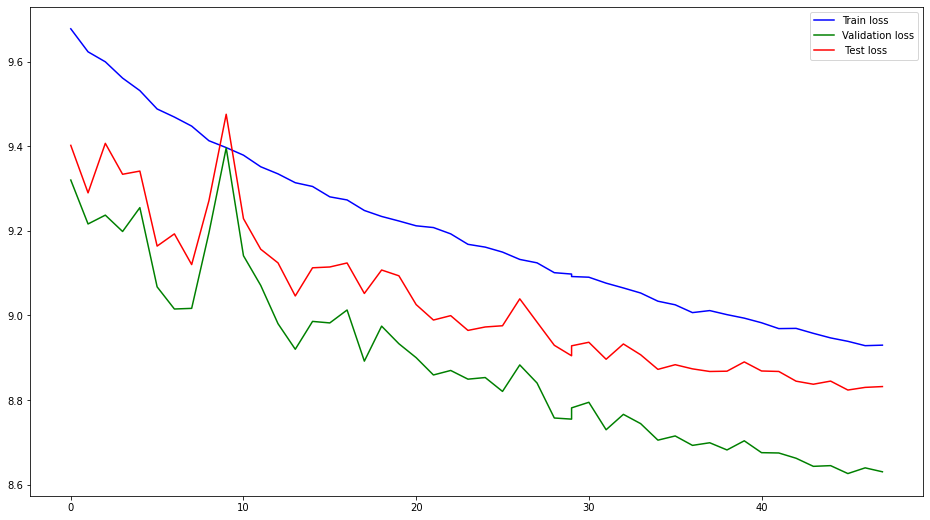

Эпоха =  48 RMSE= 8.831786155700684 
 Max_pred =  2010.0 Max_test =  2013.5358 
 Min_pred =  1927.0 Min_test =  1975.7812
Эпоха =  49


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

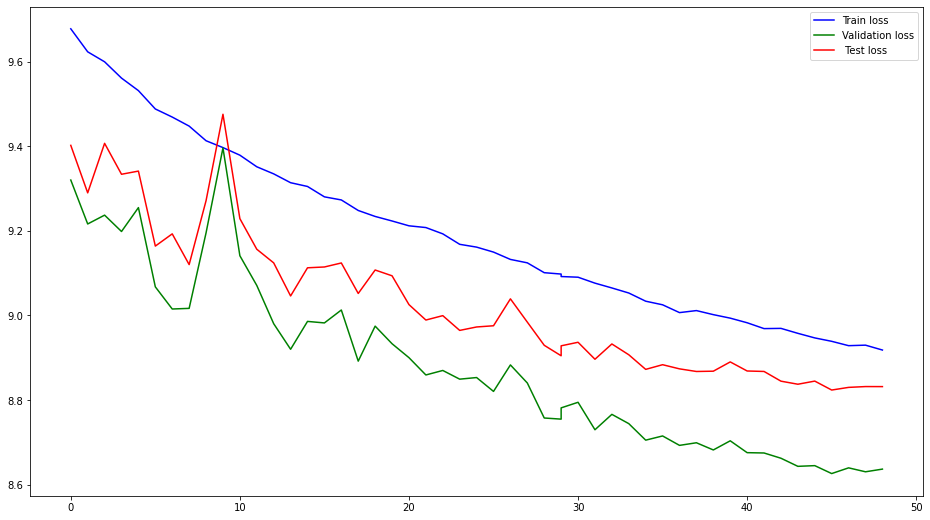

Эпоха =  49 RMSE= 8.83169174194336 
 Max_pred =  2010.0 Max_test =  2013.0521 
 Min_pred =  1927.0 Min_test =  1975.1492
Эпоха =  50


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

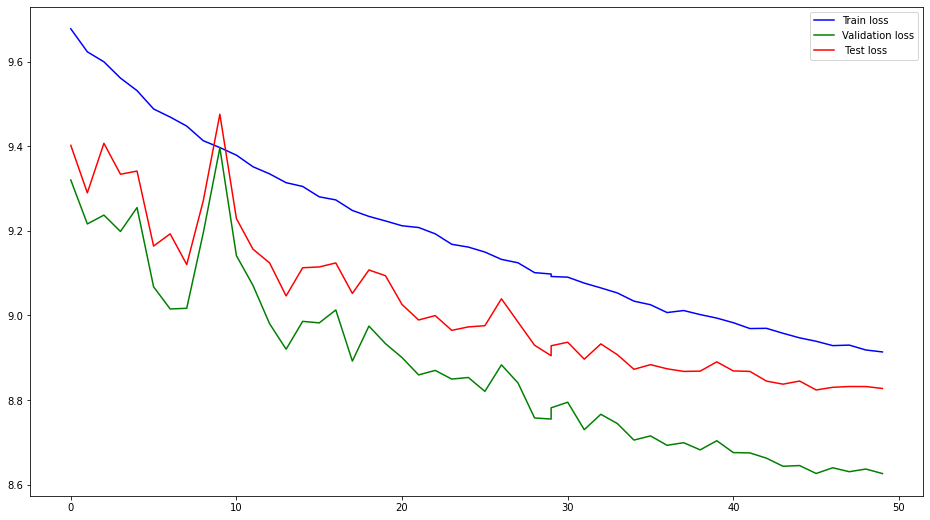

Эпоха =  50 RMSE= 8.82715892791748 
 Max_pred =  2010.0 Max_test =  2012.1023 
 Min_pred =  1927.0 Min_test =  1975.65
Эпоха =  51


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

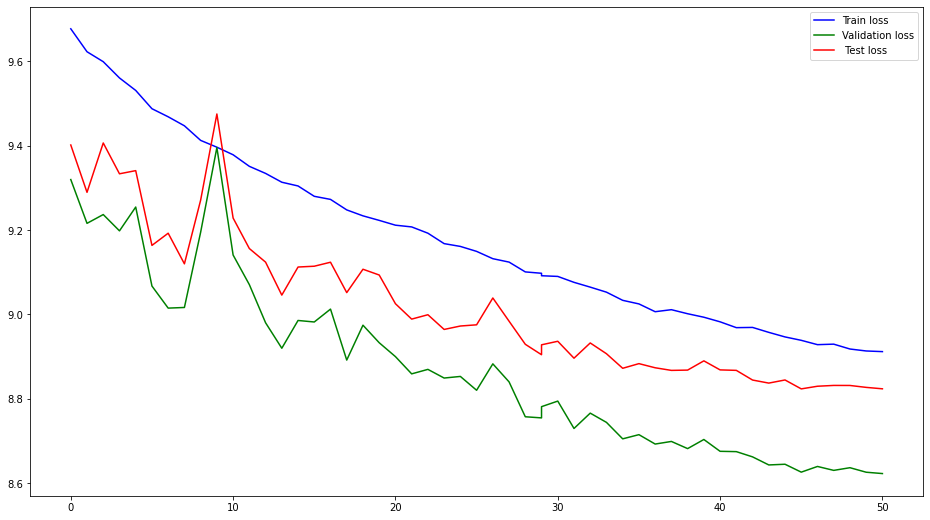

Эпоха =  51 RMSE= 8.82377815246582 
 Max_pred =  2010.0 Max_test =  2012.0734 
 Min_pred =  1927.0 Min_test =  1976.778
Эпоха =  52


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

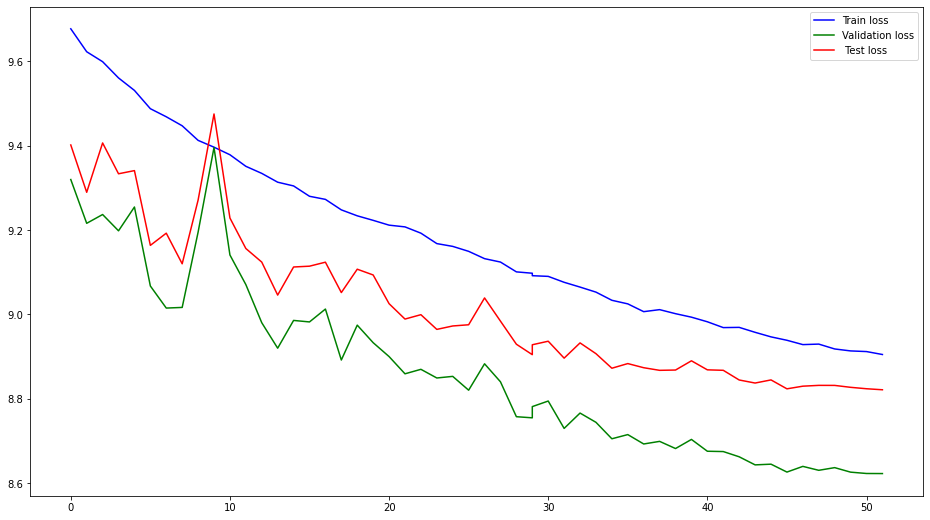

Эпоха =  52 RMSE= 8.821351051330566 
 Max_pred =  2010.0 Max_test =  2012.4327 
 Min_pred =  1927.0 Min_test =  1976.669
Эпоха =  53


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

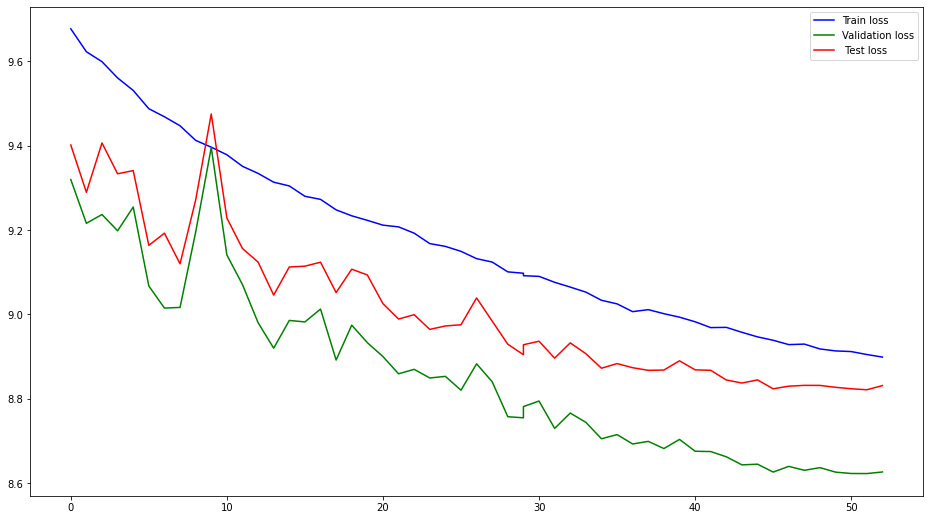

Эпоха =  53 RMSE= 8.831255912780762 
 Max_pred =  2010.0 Max_test =  2012.4144 
 Min_pred =  1927.0 Min_test =  1976.37
Эпоха =  54


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

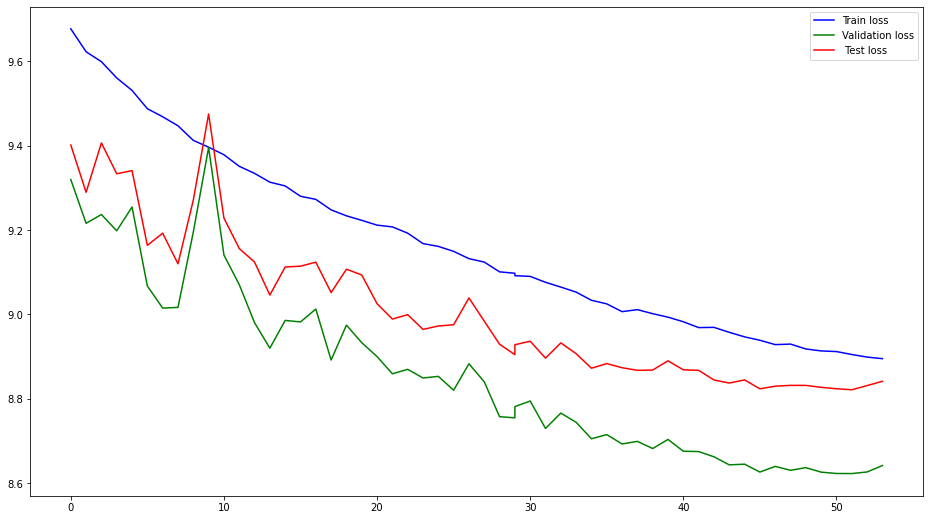

Эпоха =  54 RMSE= 8.84149169921875 
 Max_pred =  2010.0 Max_test =  2012.3011 
 Min_pred =  1927.0 Min_test =  1977.1816
Эпоха =  55


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

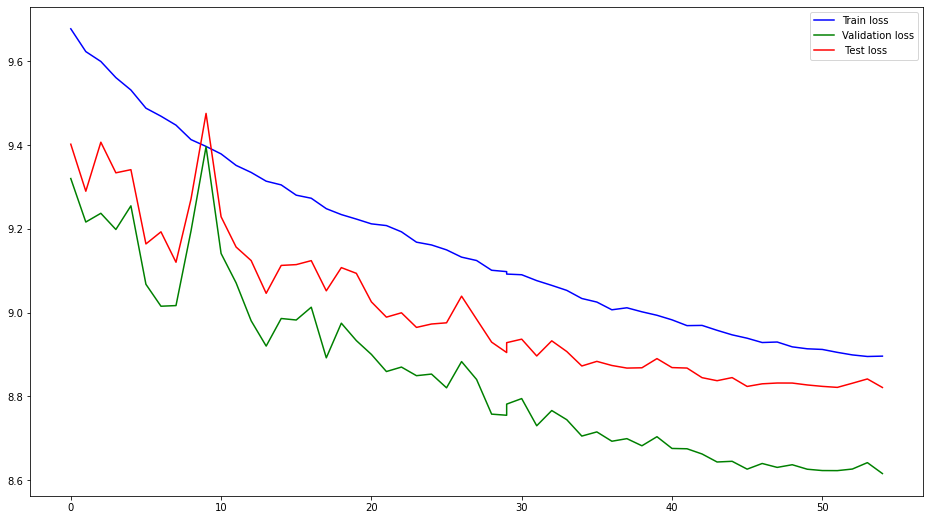

Эпоха =  55 RMSE= 8.821111679077148 
 Max_pred =  2010.0 Max_test =  2013.0327 
 Min_pred =  1927.0 Min_test =  1975.4587
Эпоха =  56


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

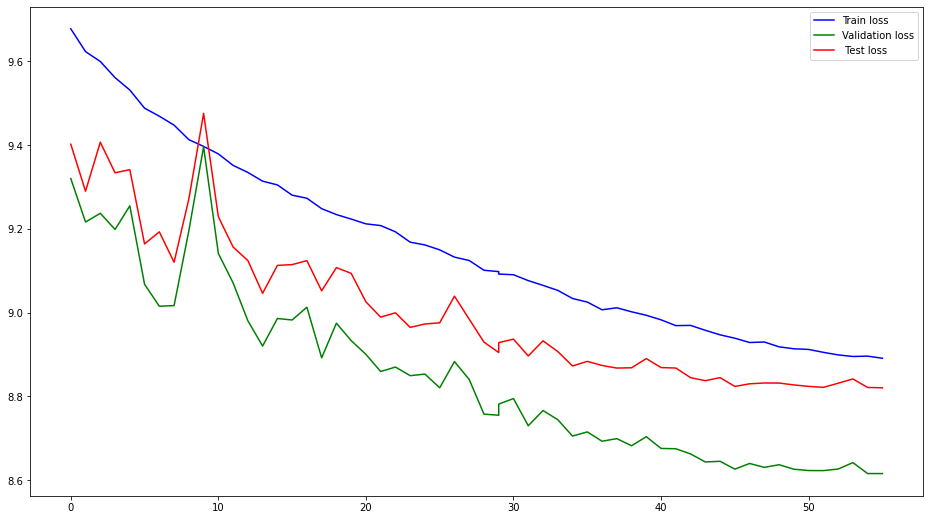

Эпоха =  56 RMSE= 8.820405960083008 
 Max_pred =  2010.0 Max_test =  2013.1605 
 Min_pred =  1927.0 Min_test =  1976.2821
Эпоха =  57


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

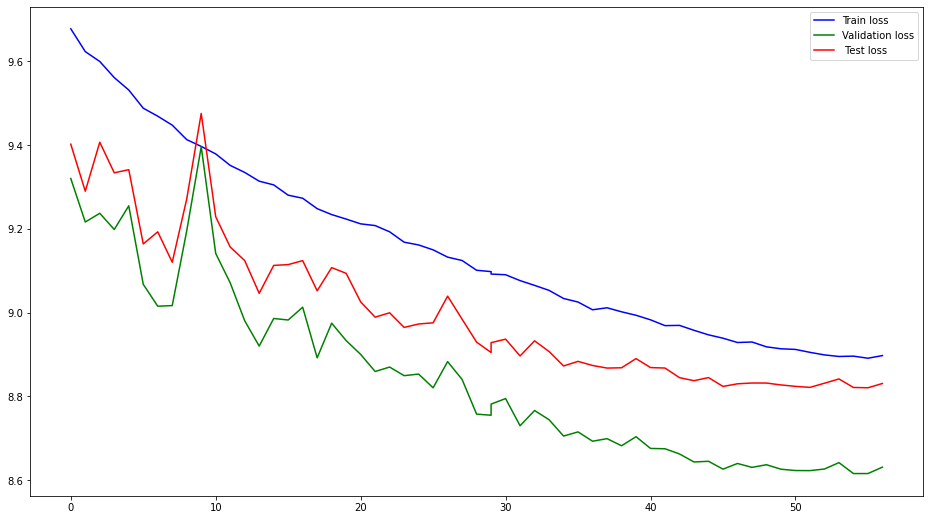

Эпоха =  57 RMSE= 8.830628395080566 
 Max_pred =  2010.0 Max_test =  2011.9907 
 Min_pred =  1927.0 Min_test =  1977.0134
Эпоха =  58


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

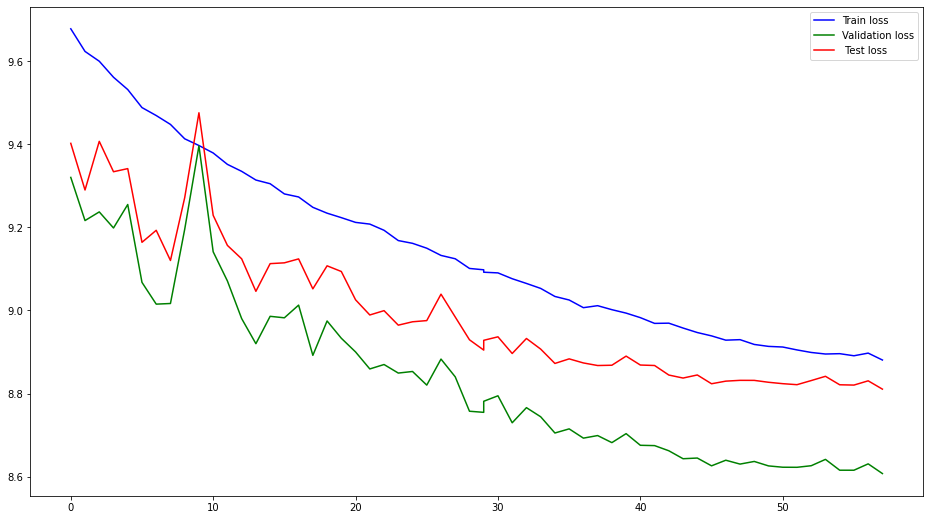

Эпоха =  58 RMSE= 8.810630798339844 
 Max_pred =  2010.0 Max_test =  2013.3958 
 Min_pred =  1927.0 Min_test =  1976.6201
Эпоха =  59


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

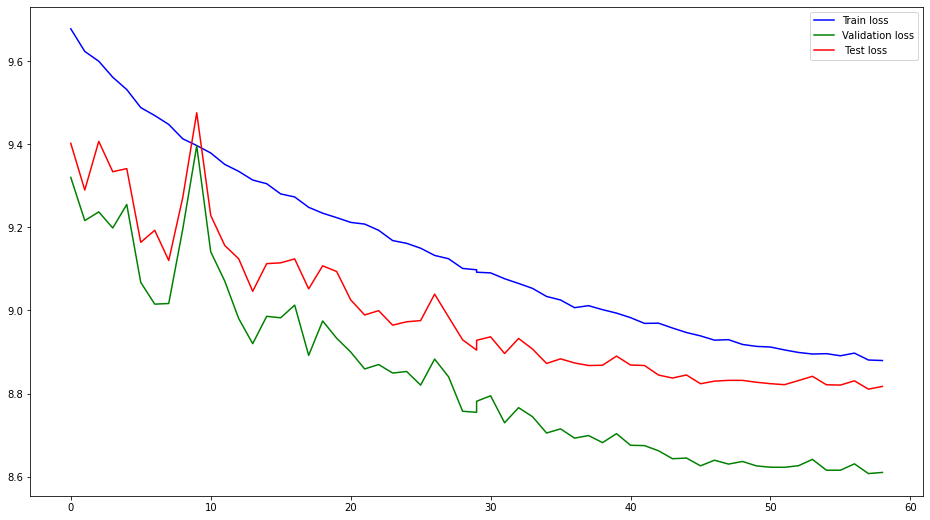

Эпоха =  59 RMSE= 8.817129135131836 
 Max_pred =  2010.0 Max_test =  2012.1433 
 Min_pred =  1927.0 Min_test =  1976.6522
Эпоха =  60


  0%|          | 0/6521 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

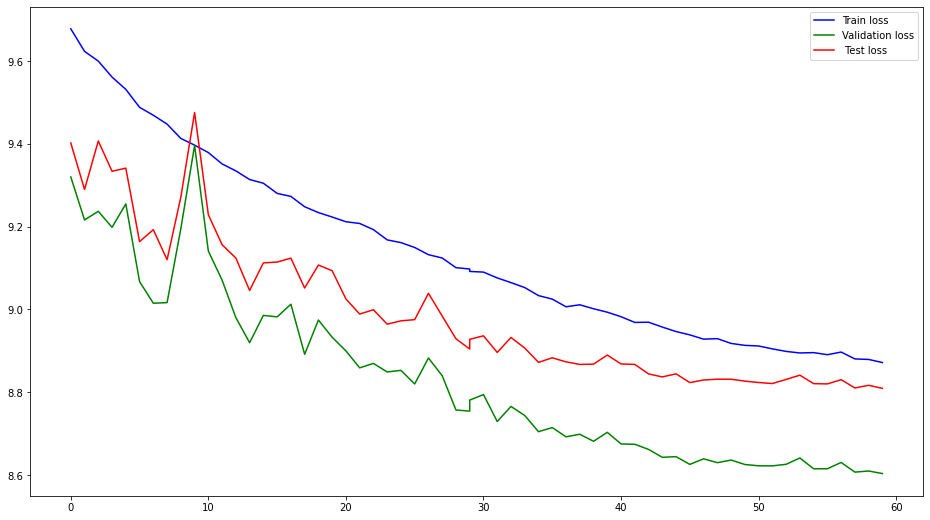

Эпоха =  60 RMSE= 8.80967903137207 
 Max_pred =  2010.0 Max_test =  2012.6766 
 Min_pred =  1927.0 Min_test =  1976.403


In [87]:
for epoch in range(29,epoches+30):
    print("Эпоха = ", epoch +1)
    epoch_ar.append(epoch)
    a= train(model, optimizer, criterion, train_loader)
    b = val(model, optimizer, criterion, val_loader)
    scheduler.step()
    trloss.append(a)
    valloss.append(b)
    t,predict, c =  test(model, criterion, test_loader)
    teloss.append(c)
    if clear:
        clear_output()
    plt.figure(figsize = (16,9))
    plt.plot(epoch_ar,trloss,color = 'blue',label = "Train loss")
    plt.plot(epoch_ar,valloss,color = 'green',label = "Validation loss")
    plt.plot(epoch_ar,teloss,color = 'red',label = " Test loss")
    plt.legend()
    plt.show()
    
    print("Эпоха = ", epoch +1,"RMSE=",float(teloss[-1]),"\n",
                 "Max_pred = ",np.max(predict),"Max_test = ",np.max(t),"\n",
                  "Min_pred = ",np.min(predict),"Min_test = ",np.min(t))

In [89]:
for i in range(3):
    print(i)

0
1
2


## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [ ]:
# YOUR CODE HERE (－.－)...zzzZZZzzzZZZ